# Anomaly Detection on Data provided by Exalens
## Preprocessing

In [1]:
import os
import sys

import ast
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import tensorflow as tf
import time

from pprint import pprint
from scipy import signal
from scipy.signal import find_peaks
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, f1_score, mean_squared_error, 
                             precision_score, recall_score)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import OneClassSVM
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (BatchNormalization, Conv1D, Dense, Dropout, 
                                     Flatten, LSTM, MaxPooling1D, RepeatVector, 
                                     Reshape, TimeDistributed, UpSampling1D)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K

2024-03-30 09:11:37.566198: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-30 09:11:37.603174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 09:11:37.603206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 09:11:37.604261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 09:11:37.610780: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check for TensorFlow GPU access.
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version.
print(f"TensorFlow version: {tf.__version__}")

# If you are on ARM-based MacOS this will return "command not found".
# In that case, you need to consider the output of above statements. 
!nvidia-smi -L
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# This is useful on Google Colab to check if high-RAM is selected.
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.15.0
GPU 0: NVIDIA RTX A6000 (UUID: GPU-76748847-01f8-4453-46b2-72ba4a516e70)
Sat Mar 30 09:11:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.02              Driver Version: 545.29.02    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:65:0

Let's see shapes.

In [3]:
# Load datasets
conveyor_training_df = pd.read_csv("/tf/dataset/ConveyorXarmData/conveyor_s7_training.csv")
conveyor_anomalous_df = pd.read_csv("/tf/dataset/ConveyorXarmData/conveyor_s7_anomaly.csv")
arm_pos_training_df = pd.read_csv("/tf/dataset/ConveyorXarmData/xarm_pos_training.csv")
arm_pos_anomalous_df = pd.read_csv("/tf/dataset/ConveyorXarmData/xarm_pos_anomaly.csv")

# Initial analysis
print("Conveyor Training Shape:", conveyor_training_df.shape)
print("Conveyor Anomalous Shape:", conveyor_anomalous_df.shape)
print("Arm Position Training Shape:", arm_pos_training_df.shape)
print("Arm Position Anomalous Shape:", arm_pos_anomalous_df.shape)

Conveyor Training Shape: (6672, 20)
Conveyor Anomalous Shape: (155, 20)
Arm Position Training Shape: (4235, 10)
Arm Position Anomalous Shape: (75, 10)


Anomalous data are very limited, check features.

In [4]:
print(conveyor_training_df.head())
print(arm_pos_training_df.head())

             ts                   timestamp   seq  \
0  1.705074e+09  2024-01-12 15:32:12.855000  7218   
1  1.705074e+09  2024-01-12 15:32:07.358000  7217   
2  1.705074e+09  2024-01-12 15:32:07.357000  7216   
3  1.705074e+09  2024-01-12 15:32:07.347000  7215   
4  1.705074e+09  2024-01-12 15:32:07.111000  7213   

                        Changed Field  step(ns=4;i=12) Material(ns=4;i=29)  \
0      I_Sensor_Right_Motor_ns_4_i_16              0.0                Wood   
1  Frequency_Output_0_0_1_HZ_ns_4_i_6              0.0                Wood   
2           Speed_Output_Rpm_ns_4_i_7              0.0                Wood   
3       Current_Output_0_01A_ns_4_i_8              0.0                Wood   
4           Speed_Output_Rpm_ns_4_i_7              0.0                Wood   

          Current Output (0  Stop(ns=4;i=27)  I_Sensor_Left_End(ns=4;i=15)  \
0   {'01A)(ns=4;i=8)': 0.0}            False                         False   
1   {'01A)(ns=4;i=8)': 0.0}            False            

Time is reversed as the 1st row is the most current one, so we fix to have chronogical order.

In [5]:
conveyor_training_df = conveyor_training_df.iloc[::-1].reset_index(drop=True)
conveyor_anomalous_df = conveyor_anomalous_df.iloc[::-1].reset_index(drop=True)
arm_pos_training_df = arm_pos_training_df.iloc[::-1].reset_index(drop=True)
arm_pos_anomalous_df = arm_pos_anomalous_df.iloc[::-1].reset_index(drop=True)

pd.options.display.float_format = '{:.0f}'.format # cancel e+09
print("First three rows from conveyor_training_df (ts and timestamp):")
print(conveyor_training_df[['ts', 'timestamp']].head(7))

print("\nFirst three rows from arm_pos_training_df (ts and timestamp):")
print(arm_pos_training_df[['ts', 'timestamp']].head(7))

First three rows from conveyor_training_df (ts and timestamp):
          ts                   timestamp
0 1705070607  2024-01-12 14:43:26.846000
1 1705070607  2024-01-12 14:43:26.857000
2 1705070609  2024-01-12 14:43:28.848000
3 1705070609  2024-01-12 14:43:28.855000
4 1705070609  2024-01-12 14:43:28.858000
5 1705070609  2024-01-12 14:43:28.863000
6 1705070609  2024-01-12 14:43:29.099000

First three rows from arm_pos_training_df (ts and timestamp):
          ts                   timestamp
0 1705070625  2024-01-12 14:43:45.186000
1 1705070625  2024-01-12 14:43:45.187000
2 1705070625  2024-01-12 14:43:45.187000
3 1705070625  2024-01-12 14:43:45.187000
4 1705070625  2024-01-12 14:43:45.187000
5 1705070625  2024-01-12 14:43:45.187000
6 1705070626  2024-01-12 14:43:46.189000


Check feature names.

In [6]:
# Extracting the feature names (column names) for both training sets
conveyor_training_features = conveyor_training_df.columns.tolist()
arm_pos_training_features = arm_pos_training_df.columns.tolist()

# Printing the feature names beautifully for training datasets
print("Conveyor Training Features:\n", conveyor_training_features, "\n")
print("Arm Position Training Features:\n", arm_pos_training_features)

Conveyor Training Features:
 ['ts', 'timestamp', 'seq', 'Changed Field', 'step(ns=4;i=12)', 'Material(ns=4;i=29)', 'Current Output (0', 'Stop(ns=4;i=27)', 'I_Sensor_Left_End(ns=4;i=15)', 'I_Sensor_Center_Pickup(ns=4;i=14)', 'VFD_Reset(ns=4;i=13)', 'Frequency Input (Hz)(ns=4;i=5)', 'Q_Motor_Reverse(ns=4;i=10)', 'Q_Stop(ns=4;i=11)', 'I_Sensor_Right_Motor(ns=4;i=16)', 'Speed Output (Rpm)(ns=4;i=7)', 'Frequency Output (0', 'Q_Motor_Forward(ns=4;i=9)', 'Start(ns=4;i=26)', 'Emergency_Stop(ns=4;i=28)'] 

Arm Position Training Features:
 ['ts', 'timestamp', 'seq', 'Changed Field', 'z(ns=2;i=4)', 'y(ns=2;i=3)', 'pitch(ns=2;i=6)', 'x(ns=2;i=2)', 'yaw(ns=2;i=7)', 'roll(ns=2;i=5)']


"Changed field" is kind of a weird feature name, we assume the others generate the same value while the feature mentioned in the "Changed field" changes. Let's confirm this.

In [7]:
# Define a function to compare row values and print changed features, excluding the first four features
def print_changed_features(df, ignore_features=['ts', 'timestamp', 'seq', 'Changed Field']):
    prev_row = None
    for i in range(20):  # Loop through the first n rows
        current_row = df.iloc[i]
        if i == 0:  # For the first row, all features are considered as "changed"
            changed_features = [feature for feature in current_row.index if feature not in ignore_features]
        else:
            # Identify features that have changed from the previous row, excluding the ignored features
            changed_features = [feature for feature in df.columns if feature not in ignore_features and current_row[feature] != prev_row[feature]]
        
        # Print the changed features
        print(f"Row {i+1} changes: {changed_features}")
        prev_row = current_row

print("Conveyor Training DataFrame Changes:")
print_changed_features(conveyor_training_df)

print("\nArm Position Training DataFrame Changes:")
print_changed_features(arm_pos_training_df)

Conveyor Training DataFrame Changes:
Row 1 changes: ['step(ns=4;i=12)', 'Material(ns=4;i=29)', 'Current Output (0', 'Stop(ns=4;i=27)', 'I_Sensor_Left_End(ns=4;i=15)', 'I_Sensor_Center_Pickup(ns=4;i=14)', 'VFD_Reset(ns=4;i=13)', 'Frequency Input (Hz)(ns=4;i=5)', 'Q_Motor_Reverse(ns=4;i=10)', 'Q_Stop(ns=4;i=11)', 'I_Sensor_Right_Motor(ns=4;i=16)', 'Speed Output (Rpm)(ns=4;i=7)', 'Frequency Output (0', 'Q_Motor_Forward(ns=4;i=9)', 'Start(ns=4;i=26)', 'Emergency_Stop(ns=4;i=28)']
Row 2 changes: ['Start(ns=4;i=26)']
Row 3 changes: ['step(ns=4;i=12)']
Row 4 changes: ['Frequency Input (Hz)(ns=4;i=5)']
Row 5 changes: ['Q_Stop(ns=4;i=11)']
Row 6 changes: ['Q_Motor_Forward(ns=4;i=9)']
Row 7 changes: ['Current Output (0']
Row 8 changes: ['Current Output (0']
Row 9 changes: ['Speed Output (Rpm)(ns=4;i=7)']
Row 10 changes: ['Frequency Output (0']
Row 11 changes: ['Current Output (0']
Row 12 changes: ['Frequency Output (0']
Row 13 changes: ['Current Output (0']
Row 14 changes: ['Speed Output (Rpm)(n

In [8]:
def check_feature_changes_uniformity(df, ignore_features=['ts', 'timestamp', 'seq', 'Changed Field']):
    prev_row = df.iloc[0]  # Start with the first row as the initial "previous" row
    changes_count = []  # List to track the number of changed features for each subsequent row
    
    for i in range(1, len(df)):  # Loop through the dataset starting from the second row
        current_row = df.iloc[i]
        # Identify features that have changed from the previous row, excluding the ignored features
        changed_features = [feature for feature in df.columns if feature not in ignore_features and current_row[feature] != prev_row[feature]]
        
        changes_count.append(len(changed_features))  # Append the count of changed features for this row
        prev_row = current_row
    
    # Get unique counts of changed features
    unique_counts = list(set(changes_count))
    
    # Check if the number of changed features is the same across all rows (ignoring the first row)
    is_uniform = len(unique_counts) == 1
    print(f"All rows (ignoring the first row) have the same number of changed features (excluding the first four features): {is_uniform}")
    if is_uniform:
        print(f"Uniform number of features change per row: {unique_counts[0]}")
    else:
        print(f"Variety in the number of features that change per row: {sorted(unique_counts)}")  # Print the sorted list of unique counts

# Call the function for the conveyor training DataFrame
check_feature_changes_uniformity(conveyor_training_df)

# Call the function for the arm position training DataFrame
check_feature_changes_uniformity(arm_pos_training_df)

All rows (ignoring the first row) have the same number of changed features (excluding the first four features): False
Variety in the number of features that change per row: [1, 2, 3]
All rows (ignoring the first row) have the same number of changed features (excluding the first four features): False
Variety in the number of features that change per row: [1, 2, 3, 4, 5, 6]


So, it is possible that, more than one feature can change at a time.

Now we focus on **conveyor belt** anomaly detection.

## Anomaly Detection

### Conveyor Belt

#### Statistical Analysis

In [9]:
anomaly_data = conveyor_anomalous_df.copy()
training_data = conveyor_training_df.copy()

# Define a function to extract the numeric value from the 'Frequency Output (0' column
def extract_numeric_value(row):
    try:
        # Convert the string representation of the dictionary into an actual dictionary
        freq_output_dict = ast.literal_eval(row)
        # Navigate through the dictionary to extract the numeric value
        value = next(iter(next(iter(freq_output_dict.values())).values()))
        return value
    except (ValueError, SyntaxError):
        return None  # Return None or an appropriate value in case of error

def extract_numeric_value_current(row):
    try:
        # Convert the string representation of the dictionary into an actual dictionary
        current_output_dict = ast.literal_eval(row)
        # Extract the numeric value directly since the structure is simpler
        value = next(iter(current_output_dict.values()))
        return value
    except (ValueError, SyntaxError):
        return None  # Return None or an appropriate value in case of error

# Apply the function to the 'Current Output (0' column for both datasets
anomaly_data['Current Output (0'] = anomaly_data['Current Output (0'].apply(extract_numeric_value_current)
training_data['Current Output (0'] = training_data['Current Output (0'].apply(extract_numeric_value_current)

# Fix formattings
anomaly_data['Frequency Output (0'] = anomaly_data['Frequency Output (0'].apply(extract_numeric_value)
training_data['Frequency Output (0'] = training_data['Frequency Output (0'].apply(extract_numeric_value)

# Calculate statistical features for both datasets
anomaly_stats = anomaly_data.describe()
training_stats = training_data.describe()

columns_to_describe = [
    'step(ns=4;i=12)', 
    'Current Output (0', 
    'Frequency Input (Hz)(ns=4;i=5)', 
    'Speed Output (Rpm)(ns=4;i=7)', 
    'Frequency Output (0'
]

# Calculate statistical features for the specified columns in both datasets
anomaly_stats = anomaly_data[columns_to_describe].describe()
training_stats = training_data[columns_to_describe].describe()

# Comparing statistical features
comparison = pd.concat([training_stats, anomaly_stats], axis=1, keys=['Training Data', 'Anomaly Data'])

comparison

Training Data                                                   \
      step(ns=4;i=12) Current Output (0 Frequency Input (Hz)(ns=4;i=5)   
count            6672              6672                           6672   
mean                5                26                             12   
std                 2                13                             10   
min                 0                 0                              0   
25%                 3                15                              5   
50%                 5                34                              5   
75%                 8                35                             25   
max                10                36                             25   

                                                          Anomaly Data  \
      Speed Output (Rpm)(ns=4;i=7) Frequency Output (0 step(ns=4;i=12)   
count                         6672                6672             155   
mean                           207                 689               5   
std                            283                 942               2   
min                           -149                -499               0   
25%                              0                   0               3   
50%                            149                 499               5   
75%                            419                1426               6   
max                            750                2499               8   

                                                        \
      Current Output (0 Frequency Input (Hz)(ns=4;i=5)   
count               155                            155   
mean                 28                             10   
std                  12                              9   
min                   0                              0   
25%                  28                              5   
50%                  34                              5   
75%                  35                             25   
max                  35                             25   

                                                        
      Speed Output (Rpm)(ns=4;i=7) Frequency Output (0  
count                          155                 155  
mean                           129                 422  
std                            298                 992  
min                           -149                -499  
25%                           -149                -499  
50%                              0                   0  
75%                            322                1065  
max                            750                2499

The only markable differences seen on **Speed** and **Freq Outputs**.

- Speed non-anomalous | anomalous mean: **207** | **129**
- Freq non-anomalous | anomalous mean: **689** | **422**

Seems like the conveyor belt **slowing down** was an anomaly. We will now do deeper analysis. We check the binary columns.

In [10]:
# Identify binary columns
binary_columns = []
for col in conveyor_training_df.columns:
    # Extract unique values and transform them to a set of their string representations, considering NaN values
    unique_values = set(conveyor_training_df[col].dropna().apply(lambda x: str(x).lower()))
    # Check if the unique values are within the expected boolean set
    if unique_values.issubset({"true", "false"}) or unique_values.issubset({"1", "0"}):
        binary_columns.append(col)

# Split the DataFrame into binary features and non-binary features
conveyor_training_binary_df = conveyor_training_df[binary_columns]
conveyor_training_non_binary_df = conveyor_training_df.drop(columns=binary_columns)

print(f"Binary Columns: {binary_columns}")

# Initialize a dictionary to hold the counts for each binary column
binary_counts = {}

# Iterate over binary columns and collect value counts for each
for col in binary_columns:
    counts = conveyor_training_binary_df[col].value_counts(normalize=False).to_dict()  # False for absolute | True for %
    # Convert counts keys to string for consistency
    counts_str = {str(key).title(): value for key, value in counts.items()}
    binary_counts[col] = counts_str

print(json.dumps(binary_counts, indent=4))

Binary Columns: ['Stop(ns=4;i=27)', 'I_Sensor_Left_End(ns=4;i=15)', 'I_Sensor_Center_Pickup(ns=4;i=14)', 'VFD_Reset(ns=4;i=13)', 'Q_Motor_Reverse(ns=4;i=10)', 'Q_Stop(ns=4;i=11)', 'I_Sensor_Right_Motor(ns=4;i=16)', 'Q_Motor_Forward(ns=4;i=9)', 'Start(ns=4;i=26)', 'Emergency_Stop(ns=4;i=28)']
{
    "Stop(ns=4;i=27)": {
        "False": 6672
    },
    "I_Sensor_Left_End(ns=4;i=15)": {
        "False": 6099,
        "True": 573
    },
    "I_Sensor_Center_Pickup(ns=4;i=14)": {
        "False": 5583,
        "True": 1089
    },
    "VFD_Reset(ns=4;i=13)": {
        "False": 6672
    },
    "Q_Motor_Reverse(ns=4;i=10)": {
        "False": 5458,
        "True": 1214
    },
    "Q_Stop(ns=4;i=11)": {
        "False": 5271,
        "True": 1401
    },
    "I_Sensor_Right_Motor(ns=4;i=16)": {
        "False": 5395,
        "True": 1277
    },
    "Q_Motor_Forward(ns=4;i=9)": {
        "True": 4068,
        "False": 2604
    },
    "Start(ns=4;i=26)": {
        "True": 6664,
        "False": 8


We see that, **Stop**, **Emergency_Stop** and **VFD_Reset** features are always 0 so they might indicate non-anomalus data.

Now we look into rest of the features. Check if the material is only "Wood".

In [11]:
# Print unique materials and their counts
print("Unique materials and their counts:")
print(conveyor_training_non_binary_df['Material(ns=4;i=29)'].value_counts())

Unique materials and their counts:
Material(ns=4;i=29)
Wood    6672
Name: count, dtype: int64


The material is always wood so can be removed as well in addition to "ts", "timestamp", "Changed Field".

In [12]:
# List of columns to exclude
columns_to_exclude = ['ts', 'timestamp', 'seq', 'Changed Field', 'Material(ns=4;i=29)']

# Create a new DataFrame excluding the specified columns, checking dynamically to avoid errors
conveyor_training_reduced_df = conveyor_training_non_binary_df.drop(columns=[col for col in columns_to_exclude if col in conveyor_training_non_binary_df.columns])

Split **Current Output** to two columns that make sense.

In [13]:
# Define a function to parse the dictionary-like string and extract the desired parts
def parse_current_output(row):
    try:
        # Convert the string representation of a dictionary to an actual dictionary
        dict_value = ast.literal_eval(row)
        # The part before 'A' is numeric
        for key, value in dict_value.items():
            key_part = key.split('A')[0]  # Split by 'A' and take the part before it
            numeric_part = ''.join(filter(str.isdigit, key_part))  # Keep only digits
            return numeric_part + 'A', value  # Append 'A' back to the numeric part and return it with the value
    except (ValueError, SyntaxError):
        # In case of any error during parsing, return None values
        return None, None

# Apply the parsing function to each row of the 'Current Output (0' column
conveyor_training_reduced_df[['Current_Output_Ampere', 'Current_Output_Value']] = conveyor_training_reduced_df['Current Output (0'].apply(lambda x: pd.Series(parse_current_output(x)))

# Drop the original 'Current Output (0' column as it's no longer needed
con_df = conveyor_training_reduced_df.drop(columns=['Current Output (0'])

print(con_df['Current_Output_Ampere'].value_counts())

Current_Output_Ampere
01A    6672
Name: count, dtype: int64


The output ampere is always **01A**, so can be dropped, we now do the same for **Frequency Output** feature.

In [14]:
# Initialize sets to collect the unique keys and 'HZ' values
unique_keys = set()
unique_hz_values = set()

# Iterate through each row in the 'Frequency Output (0' column
for row in con_df['Frequency Output (0'].values:
    try:
        # Convert the string representation of a dictionary to an actual dictionary
        freq_output = ast.literal_eval(row)
        for key, inner_dict in freq_output.items():
            unique_keys.add(key)  # Collect unique outer keys
            for inner_key in inner_dict.keys():
                # Extract and collect the part before 'HZ' from the inner key
                hz_value = inner_key.split(')')[0]
                unique_hz_values.add(hz_value)
    except ValueError:
        continue  # Skip rows where conversion fails

# Print the unique keys and 'HZ' values to see if they ever change
print("Unique keys:", unique_keys)
print("Unique 'HZ' values:", unique_hz_values)

Unique keys: {'0'}
Unique 'HZ' values: {'1 HZ'}


Only the float value changes, so we only get that.

In [15]:
# Define a function to extract the numeric value from the 'Frequency Output (0' column
def extract_numeric_value(row):
    try:
        # Convert the string representation of the dictionary into an actual dictionary
        freq_output_dict = ast.literal_eval(row)
        # Navigate through the dictionary to extract the numeric value
        value = next(iter(next(iter(freq_output_dict.values())).values()))
        return value
    except (ValueError, SyntaxError):
        return None  # Return None or an appropriate value in case of error

# Apply the function to each row of the 'Frequency Output (0' column and create a new column
con_df['Frequency_Output_Value'] = con_df['Frequency Output (0'].apply(extract_numeric_value)

# Drop the original 'Frequency Output (0' column
con = con_df.drop(columns=['Frequency Output (0', 'Current_Output_Ampere'])

Plot to gain more insight.

/tmp/ipykernel_686756/1870821311.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


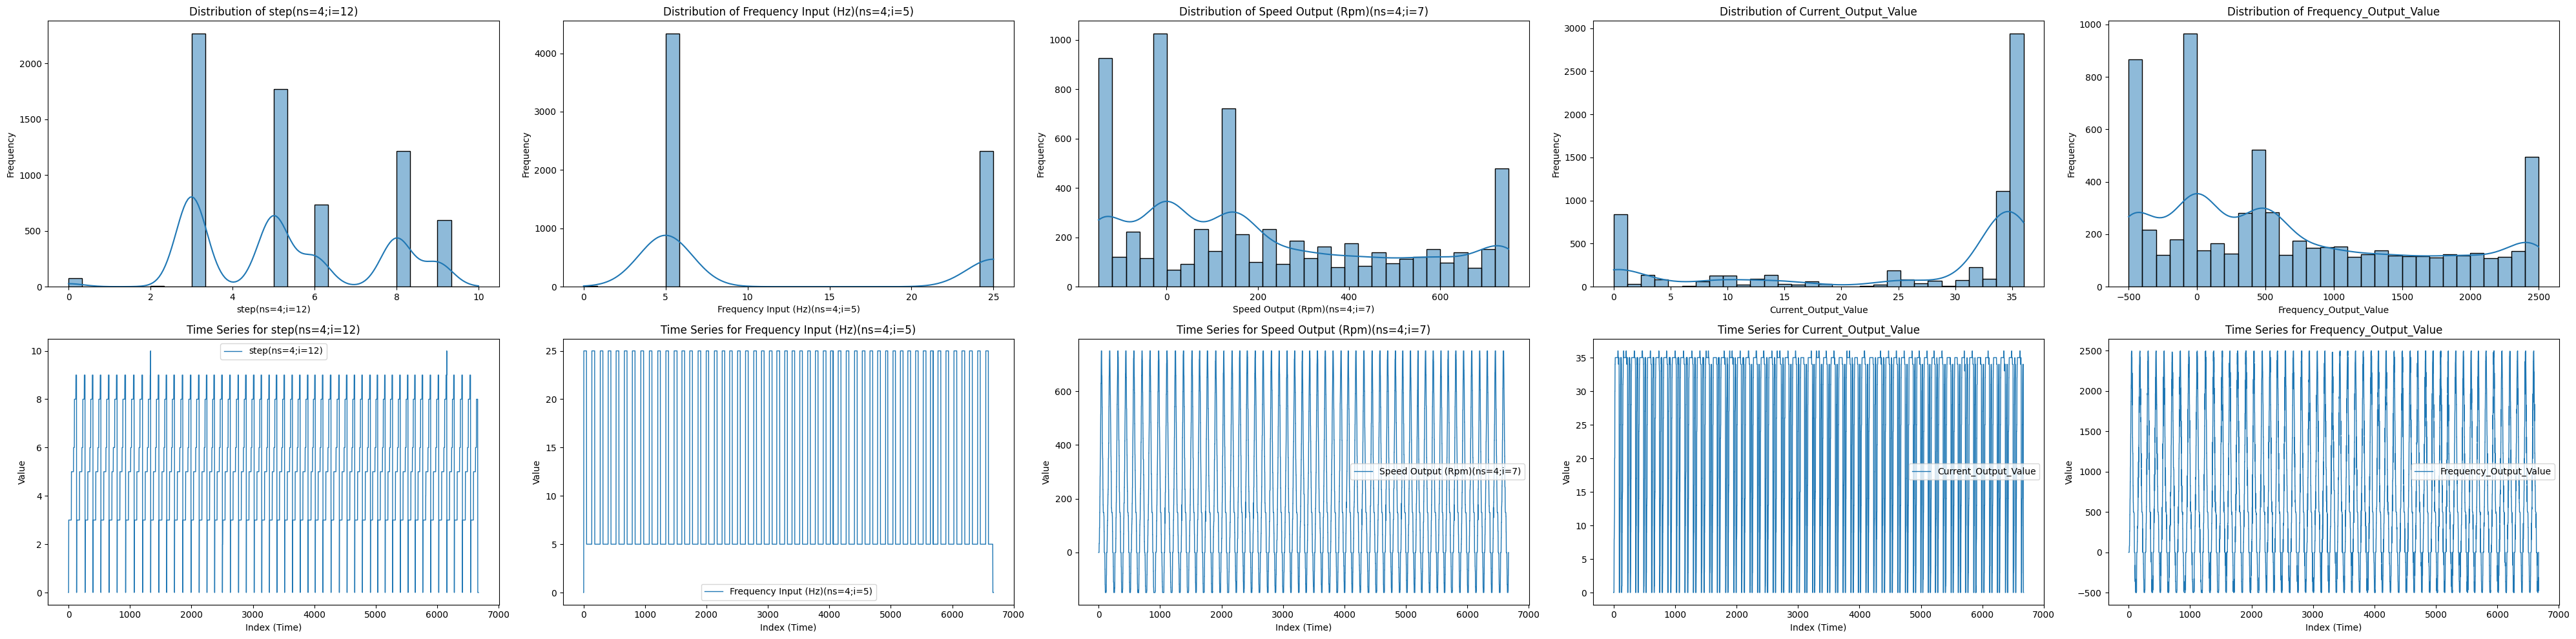

In [16]:
# Plotted features
features = ['step(ns=4;i=12)', 'Frequency Input (Hz)(ns=4;i=5)', 'Speed Output (Rpm)(ns=4;i=7)', 'Current_Output_Value', 'Frequency_Output_Value']

# Set the overall figure size and create subplots
# Adjust nrows based on the total number of features if you add or remove features
fig, axes = plt.subplots(nrows=2, ncols=len(features), figsize=(40, 10), constrained_layout=True)

# Distribution Plots for all features
for i, feature in enumerate(features):
    sns.histplot(con[feature], kde=True, bins=30, ax=axes[0, i])
    axes[0, i].set_title(f'Distribution of {feature}')
    axes[0, i].set_xlabel(f'{feature}')
    axes[0, i].set_ylabel('Frequency')

# Line Plots for all features
for i, feature in enumerate(features):
    axes[1, i].plot(con.index, con[feature], label=feature, linewidth=1)
    axes[1, i].set_title(f'Time Series for {feature}')
    axes[1, i].set_xlabel('Index (Time)')
    axes[1, i].set_ylabel('Value')
    axes[1, i].legend()

plt.tight_layout()
fig.savefig("/tf/figures/plots.pdf", format='pdf', bbox_inches='tight')
plt.show()

Periodicity can be seen well. We analyze how features correlate.

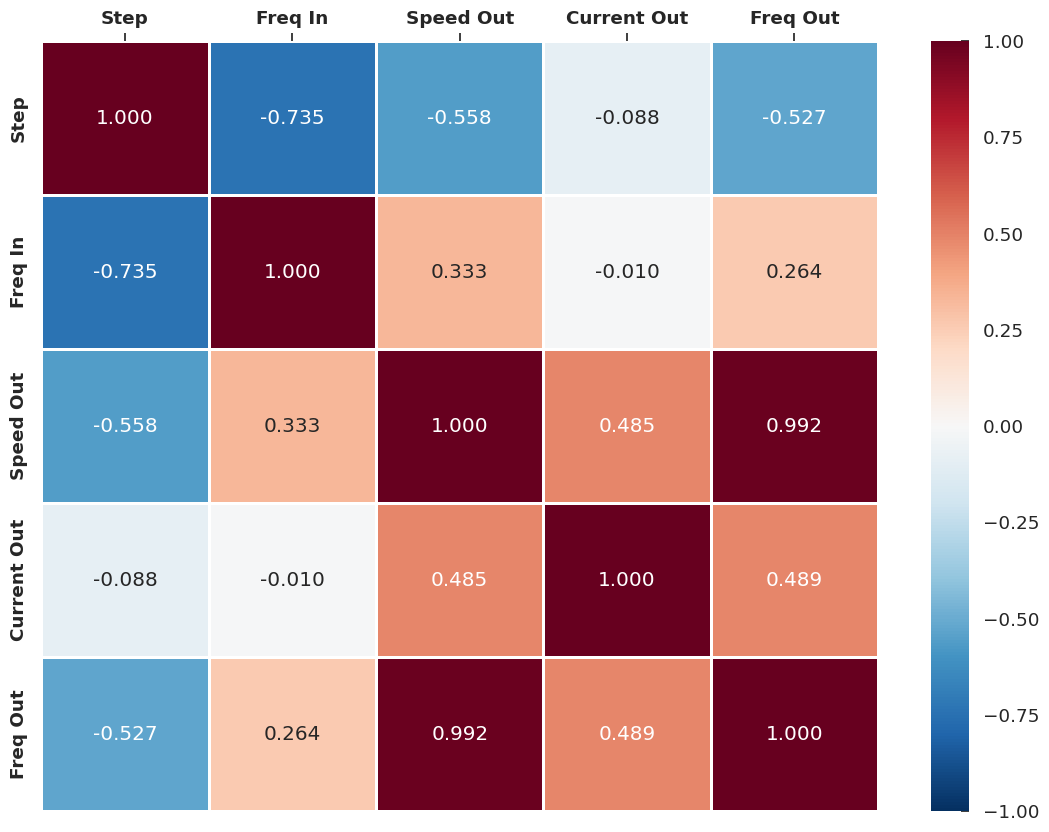

In [17]:
# New column names in the order they appear in the DataFrame
new_column_names = ['Step', 'Freq In', 'Speed Out', 'Current Out', 'Freq Out']

# Set new names directly
con.columns = new_column_names

# Calculate the correlation matrix
corr = con.corr()

# Set the size of the figure
plt.figure(figsize=(13.5, 10))

# Increase the font size for readability
sns.set(font_scale=1.2)

# Generate a heatmap with customized styling
ax = sns.heatmap(corr, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, vmax=1, 
                 cbar=True, fmt='.3f', annot_kws={"fontweight": "light"},
                 square=False, xticklabels=corr.columns, yticklabels=corr.columns)

# Get the colorbar object from the heatmap and adjust its position
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(pad=10, direction='in', labelright=True, labelleft=False)

# Adjust tick positions and labels for clarity
ax.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')

# Save the figure as a PDF with high resolution
plt.savefig('/tf/figures/corr_heatmap.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

We see that, **Freq Out** and **Speed Out** highly correlate, but for now, we will use both anyway. We now look into anomalous data. First we check the binary columns.

In [18]:
# Identify binary columns more robustly, considering columns with one type of binary value
binary_columns = []
for col in conveyor_anomalous_df.columns:
    # Extract unique values and transform them to a set of their string representations, considering NaN values
    unique_values = set(conveyor_anomalous_df[col].dropna().apply(lambda x: str(x).lower()))
    # Check if the unique values are within the expected boolean set
    if unique_values.issubset({"true", "false"}) or unique_values.issubset({"1", "0"}):
        binary_columns.append(col)

# Split the DataFrame into binary features and non-binary features
conveyor_anomalous_binary_df = conveyor_anomalous_df[binary_columns]
conveyor_anomalous_non_binary_df = conveyor_anomalous_df.drop(columns=binary_columns)

print(f"Binary Columns: {binary_columns}")

# Initialize a dictionary to hold the counts for each binary column
binary_counts = {}

# Iterate over binary columns and collect value counts for each
for col in binary_columns:
    counts = conveyor_anomalous_binary_df[col].value_counts(normalize=False).to_dict()  # Use normalize=False for absolute counts
    # Convert counts keys to string for consistency
    counts_str = {str(key).title(): value for key, value in counts.items()}
    binary_counts[col] = counts_str

print(json.dumps(binary_counts, indent=4))

Binary Columns: ['Stop(ns=4;i=27)', 'I_Sensor_Left_End(ns=4;i=15)', 'I_Sensor_Center_Pickup(ns=4;i=14)', 'VFD_Reset(ns=4;i=13)', 'Q_Motor_Reverse(ns=4;i=10)', 'Q_Stop(ns=4;i=11)', 'I_Sensor_Right_Motor(ns=4;i=16)', 'Q_Motor_Forward(ns=4;i=9)', 'Start(ns=4;i=26)', 'Emergency_Stop(ns=4;i=28)']
{
    "Stop(ns=4;i=27)": {
        "False": 155
    },
    "I_Sensor_Left_End(ns=4;i=15)": {
        "False": 143,
        "True": 12
    },
    "I_Sensor_Center_Pickup(ns=4;i=14)": {
        "False": 132,
        "True": 23
    },
    "VFD_Reset(ns=4;i=13)": {
        "False": 155
    },
    "Q_Motor_Reverse(ns=4;i=10)": {
        "False": 99,
        "True": 56
    },
    "Q_Stop(ns=4;i=11)": {
        "False": 128,
        "True": 27
    },
    "I_Sensor_Right_Motor(ns=4;i=16)": {
        "False": 137,
        "True": 18
    },
    "Q_Motor_Forward(ns=4;i=9)": {
        "False": 85,
        "True": 70
    },
    "Start(ns=4;i=26)": {
        "True": 145,
        "False": 10
    },
    "Emergency

Similar to non-anomalous data, **Stop**, **VFD_Reset**, and **Emergency_Stop** are always False, so they cannot be utilized as anomaly indicators. We now apply the exact same process, where we get only 5 features (2 discrete, 3 continous).

In [19]:
# Columns to keep
columns_to_keep = [
    'step(ns=4;i=12)', 
    'Current Output (0',
    'Frequency Input (Hz)(ns=4;i=5)', 
    'Speed Output (Rpm)(ns=4;i=7)', 
    'Frequency Output (0'
]

# Creating a copy of the filtered DataFrame to avoid SettingWithCopyWarning
df_filtered = conveyor_anomalous_df[columns_to_keep].copy()

# Convert string representations of dictionaries to dictionaries and extract the last numerical value
df_filtered['Current Output (0'] = df_filtered['Current Output (0'].apply(
    lambda x: list(ast.literal_eval(x).values())[-1] if isinstance(x, str) else x
)

df_filtered['Frequency Output (0'] = df_filtered['Frequency Output (0'].apply(
    lambda x: list(ast.literal_eval(x)['0'].values())[-1] if isinstance(x, str) and '0' in ast.literal_eval(x) else x
)

Based on our findings here, we plot the non-anomalous and anomalous Speed Output.

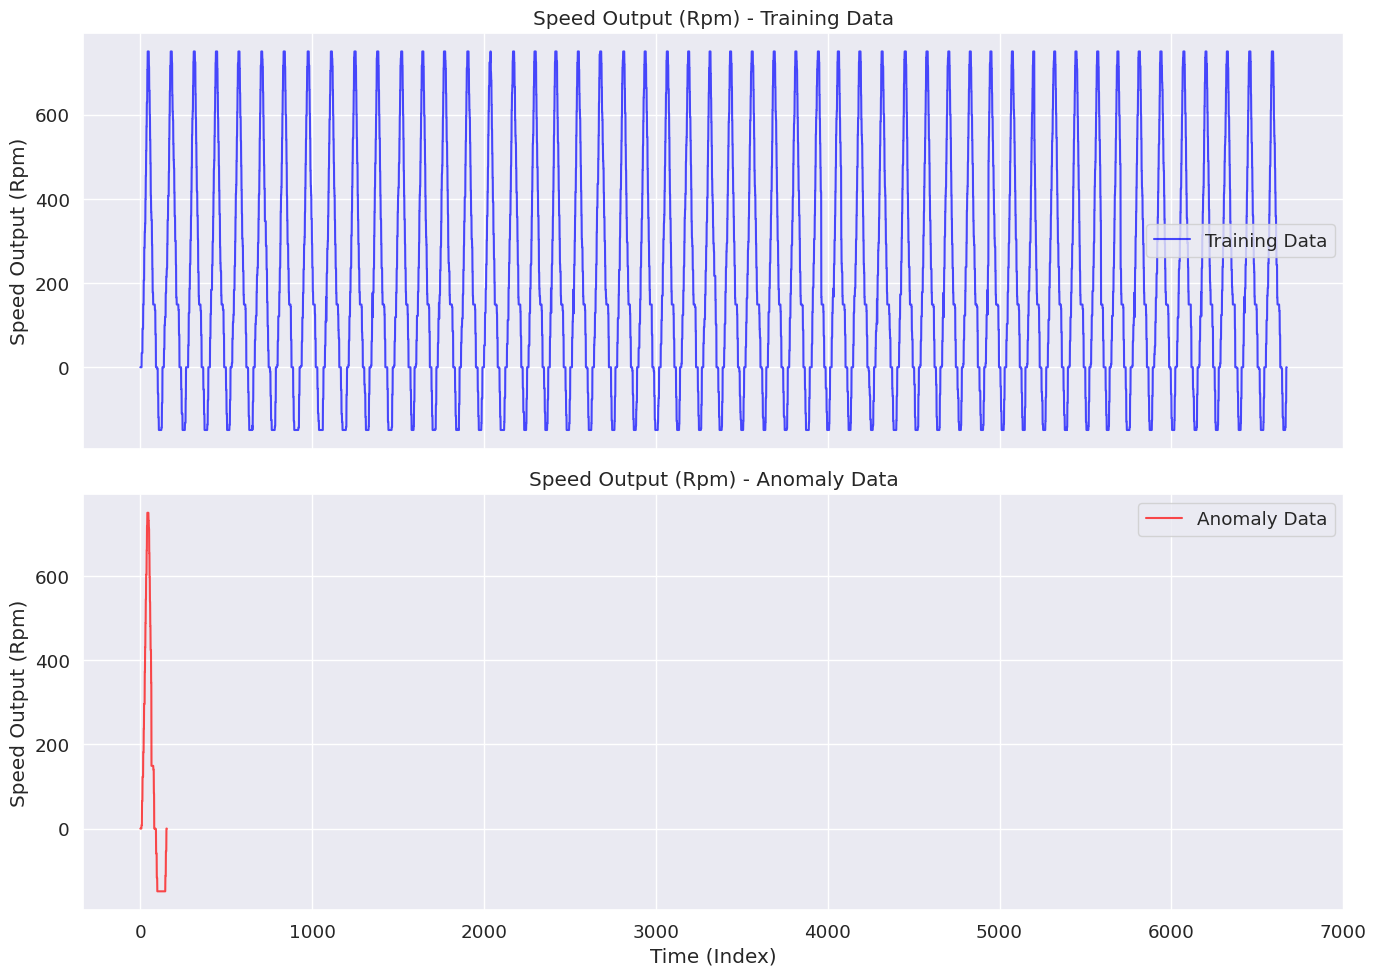

In [20]:
# Creating subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

# Plotting Training Data
axes[0].plot(conveyor_training_df['Speed Output (Rpm)(ns=4;i=7)'], label='Training Data', color='blue', alpha=0.7)
axes[0].set_title('Speed Output (Rpm) - Training Data')
axes[0].set_ylabel('Speed Output (Rpm)')
axes[0].legend()

# Plotting Anomaly Data
axes[1].plot(conveyor_anomalous_df['Speed Output (Rpm)(ns=4;i=7)'], label='Anomaly Data', color='red', alpha=0.7)
axes[1].set_title('Speed Output (Rpm) - Anomaly Data')
axes[1].set_xlabel('Time (Index)')
axes[1].set_ylabel('Speed Output (Rpm)')
axes[1].legend()

plt.tight_layout()
plt.show()

Now the issue is much clearer. This graph also confirms, The anomaly happened after a while, so not all data points are anomalous. We identify the lowest point first and analyze its consecutive appearances.

In [21]:
min_value = conveyor_anomalous_df['Speed Output (Rpm)(ns=4;i=7)'].min()
consecutive_counts = (conveyor_anomalous_df['Speed Output (Rpm)(ns=4;i=7)'] == min_value).astype(int).groupby(conveyor_anomalous_df['Speed Output (Rpm)(ns=4;i=7)'].ne(min_value).cumsum()).sum()
max_consecutive = consecutive_counts.max()
is_neg_149 = conveyor_training_df['Speed Output (Rpm)(ns=4;i=7)'] == -149
consecutive_groups = is_neg_149.ne(is_neg_149.shift()).cumsum()
filtered_groups = consecutive_groups[is_neg_149]
group_sizes = filtered_groups.value_counts()
average_consecutive_neg_149 = group_sizes.mean()

min_value, max_consecutive, average_consecutive_neg_149

(-149.0, 47, 13.49090909090909)

We confirmed that, the value of **-149** overall consecutively appears with 13 data points while in anomalous case there are 47 consecutive appearances, so we set our labels based on that.

In [22]:
###
# MULTIVARIATE ANALYSIS
###

# # Rename so it makes sense - ns for no scaling
# anol_df_ns = df_filtered
# anol_df_ns.columns = ['Step', 'Current Out', 'Freq In', 'Speed Out', 'Freq Out']

# # Swap the places
# anol_df_ns = anol_df_ns[['Step', 'Freq In', 'Speed Out', 'Current Out', 'Freq Out']]

# # Create a numpy array with 0s matching the length of anol_df
# anol_labels = np.zeros(len(anol_df_ns))
# # Find the index where -149 starts
# start_index = anol_df_ns[anol_df_ns['Speed Out'] == -149].index[0]
# # Set the values to 1 after the 13th consecutive point of -149
# anol_labels[start_index + 13:] = 1

# # Calculate split indices
# train_size = int(len(con) * 0.6)
# val_size = int(len(con) * 0.2)

# # Split the DataFrame
# train_df_ns = con.iloc[:train_size]
# val_df_ns = con.iloc[train_size:train_size + val_size]
# test_df_ns = con.iloc[train_size + val_size:]

# # Initialize the scaler
# scaler = StandardScaler()

# # Fit the scaler on the training data and transform it
# train_scaled = scaler.fit_transform(train_df_ns)
# val_scaled = scaler.transform(val_df_ns)
# test_scaled = scaler.transform(test_df_ns)
# anol_scaled = scaler.transform(anol_df_ns)

# # Convert scaled numpy arrays back to pandas DataFrames
# train_df = pd.DataFrame(train_scaled, columns=train_df_ns.columns, index=train_df_ns.index)
# val_df = pd.DataFrame(val_scaled, columns=val_df_ns.columns, index=val_df_ns.index)
# test_df = pd.DataFrame(test_scaled, columns=test_df_ns.columns, index=test_df_ns.index)
# anol_df = pd.DataFrame(anol_scaled, columns=anol_df_ns.columns, index=anol_df_ns.index)

# # Check the lengths
# print("Lengths: ", len(train_scaled), len(val_scaled), len(test_scaled), len(anol_scaled))
# print("Lengths: ", len(train_df), len(val_df), len(test_df), len(anol_df))

###
# UNIVARIATE ANALYSIS
###

# Selecting the 'Speed Out' column for analysis - No Scaling version
anol_df_ns = df_filtered[['Speed Output (Rpm)(ns=4;i=7)']].rename(columns={'Speed Output (Rpm)(ns=4;i=7)': 'Speed Out'})

# Create a numpy array with 0s matching the length of anol_df_ns
anol_labels = np.zeros(len(anol_df_ns))
# Find the index where -149 starts
start_index = anol_df_ns[anol_df_ns['Speed Out'] == -149].index[0]
# Set the values to 1 after the 13th consecutive point of -149
anol_labels[start_index + 13:] = 1

# Calculate split indices
train_size = int(len(con) * 0.6)
val_size = int(len(con) * 0.2)

# Split the 'Speed Out' column from 'con'
train_df_ns = con.iloc[:train_size][['Speed Out']]
val_df_ns = con.iloc[train_size:train_size + val_size][['Speed Out']]
test_df_ns = con.iloc[train_size + val_size:][['Speed Out']]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
train_scaled = scaler.fit_transform(train_df_ns)
val_scaled = scaler.transform(val_df_ns)
test_scaled = scaler.transform(test_df_ns)
anol_scaled = scaler.transform(anol_df_ns)

# Convert scaled numpy arrays back to pandas DataFrames with 'Speed Out' as the column
train_df = pd.DataFrame(train_scaled, columns=['Speed Out'], index=train_df_ns.index)
val_df = pd.DataFrame(val_scaled, columns=['Speed Out'], index=val_df_ns.index)
test_df = pd.DataFrame(test_scaled, columns=['Speed Out'], index=test_df_ns.index)
anol_df = pd.DataFrame(anol_scaled, columns=['Speed Out'], index=anol_df_ns.index)

# Check the lengths
print("Lengths: ", len(train_scaled), len(val_scaled), len(test_scaled), len(anol_scaled))
print("Lengths: ", len(train_df), len(val_df), len(test_df), len(anol_df))

Lengths:  4003 1334 1335 155
Lengths:  4003 1334 1335 155


We just check to see how it looks after scaling.

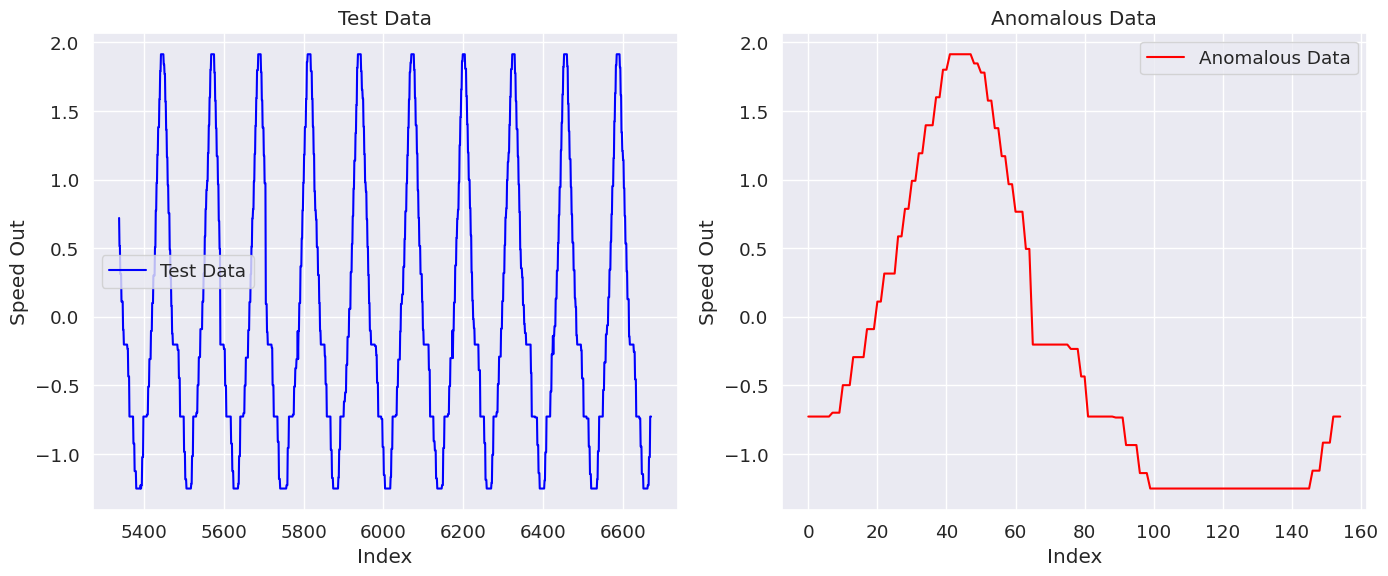

In [23]:
# Plotting the test data
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(test_df.index, test_df['Speed Out'], label='Test Data', color='blue')
plt.title('Test Data')
plt.xlabel('Index')
plt.ylabel('Speed Out')
plt.legend()

# Plotting the anomalous data
plt.subplot(1, 2, 2)
plt.plot(anol_df.index, anol_df['Speed Out'], label='Anomalous Data', color='red')
plt.title('Anomalous Data')
plt.xlabel('Index')
plt.ylabel('Speed Out')
plt.legend()

plt.tight_layout()
plt.show()

Let's see how it autocorrelates (periodicity).

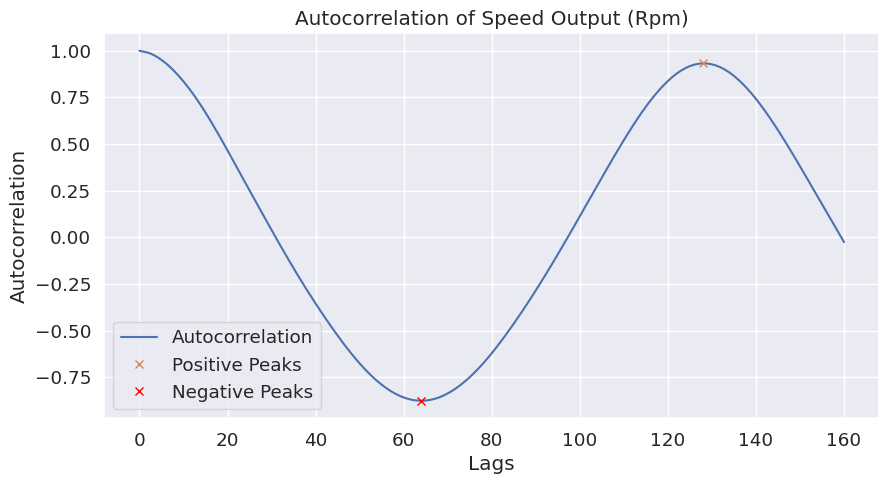

Positive peaks are at lags: [128]
Negative peaks are at lags: [64]


In [24]:
# Compute the autocorrelation and find peaks
speed_output = conveyor_training_df['Speed Output (Rpm)(ns=4;i=7)']
autocorrelation = acf(speed_output, nlags=160, fft=True)
peaks, _ = find_peaks(autocorrelation)
neg_peaks, _ = find_peaks(-autocorrelation)  # For negative peaks

# Plotting the autocorrelation
plt.figure(figsize=(10, 5))
plt.plot(autocorrelation, label='Autocorrelation')

# Marking the positive peaks
plt.plot(peaks, autocorrelation[peaks], "x", label='Positive Peaks')

# Marking the negative peaks
plt.plot(neg_peaks, autocorrelation[neg_peaks], "x", color='red', label='Negative Peaks')

plt.title('Autocorrelation of Speed Output (Rpm)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

# Print the lags where peaks occur
print(f"Positive peaks are at lags: {peaks}")
print(f"Negative peaks are at lags: {neg_peaks}")

We can start setting our window size to 64. Now we move into **training**.

#### Method 1: 1D-CNN

In [25]:
patience = 3
batch_size = 32
sequence_stride = 1
WIN_SIZE_CONV = 64
CONV_WIDTH = 3
MAX_EPOCHS = 100
NUM_FILTERS = 8
MAX_POOL_SIZE = 3
NUM_FEATURES = 1
OUT_SIZE = 1

def compile_and_fit(model, window, patience=patience):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adamax(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                 [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                  axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
             data=data,
             targets=None,
             sequence_length=self.total_window_size,
             sequence_stride=sequence_stride,
             shuffle=False,
             batch_size=batch_size,)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)
@property
def anol(self):
    return self.make_dataset(self.anol_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, anol_df, label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.anol_df = anol_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.anol = anol
WindowGenerator.example = example

# Set neural network model/parameters.
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    # tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    # tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    # tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT_SIZE*NUM_FEATURES, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_SIZE, NUM_FEATURES])
])

val_performance = {}
loss = {}
val_loss = {}

cnn_model.build(input_shape=(None, WIN_SIZE_CONV, NUM_FEATURES))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 62, 8)             32        
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 8)             200       
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 8)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
 reshape (Reshape)           (None, 1, 1)              0         
                                                        

2024-03-30 09:12:00.226390: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46646 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6


In [26]:
# Set window.
w1_con = WindowGenerator(input_width=WIN_SIZE_CONV, label_width=OUT_SIZE, shift=OUT_SIZE,
                     train_df=train_df, val_df=val_df, test_df=test_df, anol_df=anol_df)

# Verify the model input/output shape.
print('Input shape:', w1_con.example[0].shape)
print('Output shape:', cnn_model(w1_con.example[0]).shape)

Input shape: (32, 64, 1)


2024-03-30 09:12:03.416959: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


Output shape: (32, 1, 1)


In [38]:
# Train the model.
# Compile and evaluate.
history = compile_and_fit(cnn_model, w1_con)

Epoch 1/100


2024-03-26 13:41:17.525756: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f884d26f170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-26 13:41:17.525788: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-03-26 13:41:17.530716: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711460477.619018 2542280 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


124/124 [==============================] - 3s 11ms/step - loss: 0.5588 - root_mean_squared_error: 0.7475 - val_loss: 0.1633 - val_root_mean_squared_error: 0.4041
Epoch 2/100
124/124 [==============================] - 1s 8ms/step - loss: 0.0719 - root_mean_squared_error: 0.2682 - val_loss: 0.0473 - val_root_mean_squared_error: 0.2176
Epoch 3/100
124/124 [==============================] - 1s 8ms/step - loss: 0.0327 - root_mean_squared_error: 0.1809 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1949
Epoch 4/100
124/124 [==============================] - 1s 8ms/step - loss: 0.0281 - root_mean_squared_error: 0.1676 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1844
Epoch 5/100
124/124 [==============================] - 1s 8ms/step - loss: 0.0246 - root_mean_squared_error: 0.1567 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1740
Epoch 6/100
124/124 [==============================] - 1s 8ms/step - loss: 0.0214 - root_mean_squared_error: 0.1462 - val_loss: 0.0271 - val_root_

Saving methods differ. Use first one to easily to load and use (high-level API), for TFLite and TFLite Micro use the second method.

In [29]:
# MODEL_DIR = "/tf/models/1d_cnn_uni_easy"

# # Just save the model; no need for tf.function or concrete functions
# cnn_model.save(MODEL_DIR, save_format="tf")

# # Adjust the input shape for 1D-CNN: batch size, window size for convolution, number of features
# BATCH_SIZE = 1
# STEPS = WIN_SIZE_CONV 
# INPUT_SIZE = NUM_FEATURES

# # Wrap the model call with tf.function for optimization
# run_model = tf.function(lambda x: cnn_model(x))

# # Create a concrete function from the model to fix the input size
# concrete_func = run_model.get_concrete_function(
#     tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], cnn_model.inputs[0].dtype))

# # Model directory to save the TensorFlow SavedModel
# MODEL_DIR = "/tf/models/1d_cnn_uni"
# cnn_model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

# To load the model, uncomment the following line
MODEL_DIR = "/tf/models/1d_cnn_uni"
cnn_model = tf.keras.models.load_model(MODEL_DIR)

40/40 [==============================] - 0s 4ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082
{'1D-CNN': [0.011707564815878868, 0.10820149630308151]}


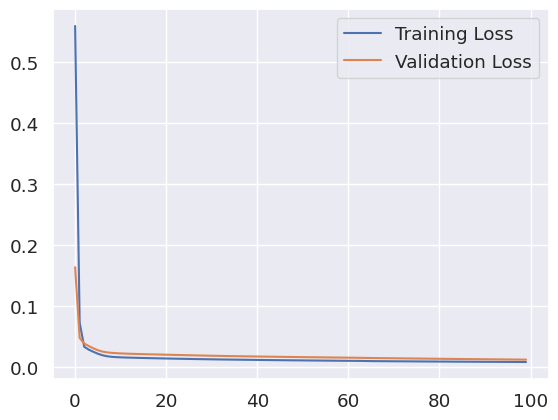

In [40]:
val_performance["1D-CNN"] = cnn_model.evaluate(w1_con.val, verbose=1, return_dict=False)
loss["1D-CNN"] = history.history["loss"]
val_loss["1D-CNN"] = history.history["val_loss"]
pprint(val_performance)

# Plot the loss graph.
plt.plot(loss["1D-CNN"], label='Training Loss')
plt.plot(val_loss["1D-CNN"], label='Validation Loss')
plt.legend()
plt.savefig("/tf/figures/1d_cnn_uni.pdf", facecolor='white')
plt.show()

The loss graph is very promising. Now we are ready to predict, so we will **predict** them now.

In [30]:
# Predict test data.
test_pred = cnn_model.predict(w1_con.test, batch_size=32)
reshaped_test = test_pred.reshape(-1, NUM_FEATURES)
rescaled_test = scaler.inverse_transform(reshaped_test)
adjusted_test = test_df_ns.to_numpy()[WIN_SIZE_CONV:]
rmse_per_row_test = np.sqrt(np.mean(np.square(rescaled_test - adjusted_test), axis=1))

# Predict anomalous data.
anomalous_preds = cnn_model.predict(w1_con.anol, batch_size=32)
reshaped_ha = anomalous_preds.reshape(-1, NUM_FEATURES)
rescaled_ha = scaler.inverse_transform(reshaped_ha)
adjusted_ha = anol_df_ns.to_numpy()[WIN_SIZE_CONV:]
rmse_per_row_anol = np.sqrt(np.mean(np.square(rescaled_ha - adjusted_ha), axis=1))

3/3 [==============================] - 0s 46ms/step


Let's see how **anomalous data** are predicted.

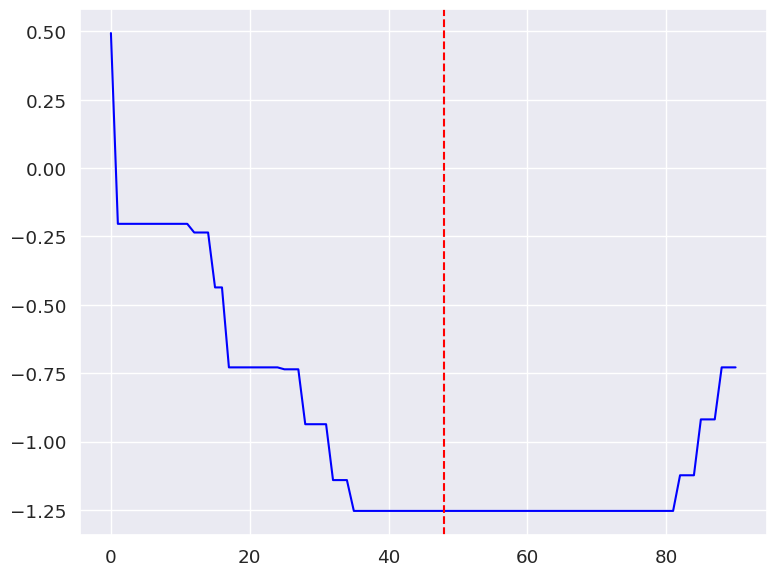

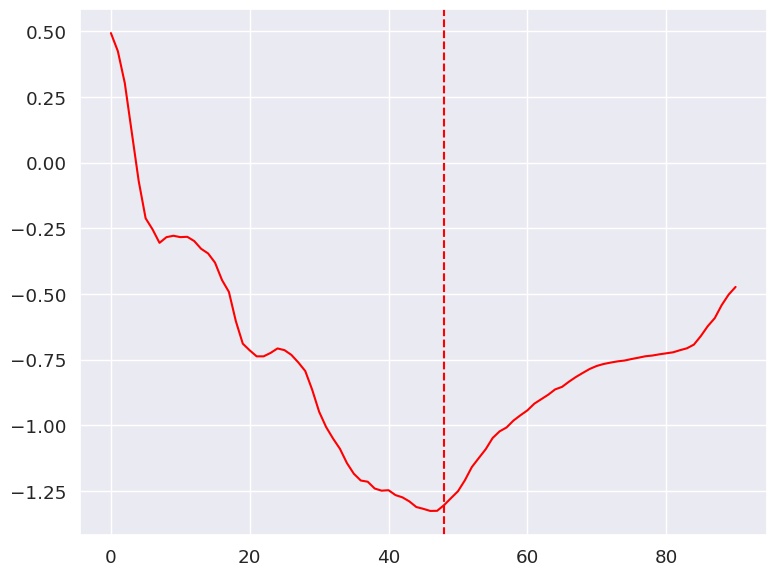

In [40]:
# Reshaping the predictions for plotting
anomalous_pred_reshaped = anomalous_preds.reshape(-1)

# Plotting test predictions as a separate figure
plt.figure(figsize=(8, 6))
plt.plot(anol_df[WIN_SIZE_CONV:].to_numpy(), color='blue')
plt.axvline(x=48, color='red', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.savefig("/tf/figures/1d_cnn_example_test_preds.pdf", facecolor='white')
plt.show()

# Plotting anomalous predictions as a separate figure
plt.figure(figsize=(8, 6))
plt.plot(anomalous_pred_reshaped, color='red')
plt.axvline(x=48, color='red', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.savefig("/tf/figures/1d_cnn_example_anomalous_preds.pdf", facecolor='white')
plt.show()

Remember where the 1st anomaly is seen.

In [41]:
# Find the indices where the value is 1
indices = np.where(anol_labels == 1)[0]

# Get the first occurrence if it exists
first_occurrence = indices[0] if len(indices) > 0 else None

print("Index of the first occurrence of 1:", first_occurrence)

Index of the first occurrence of 1: 112


As the first anomaly seen at 112, we would except prediction differ around the point (112-64) **48**, which seems like the case. Now we compare **RMSE** plots.

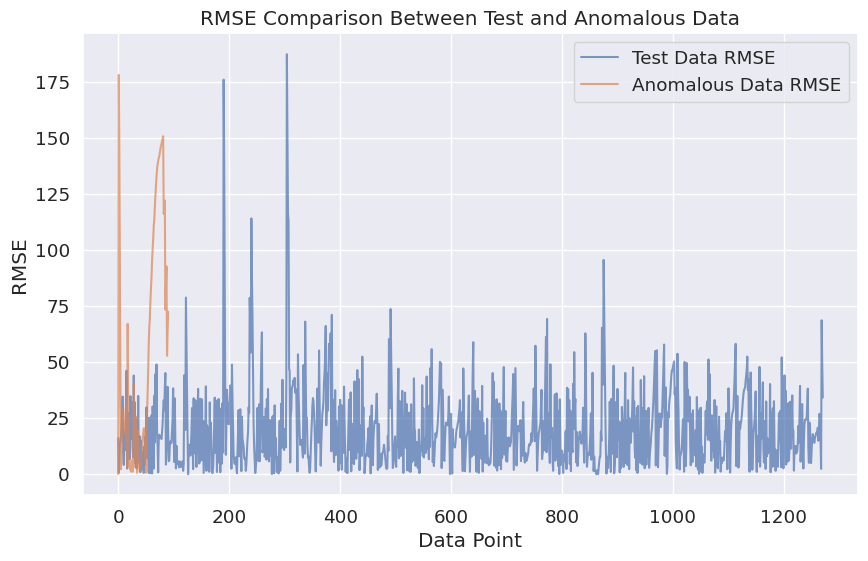

In [42]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(rmse_per_row_test, label='Test Data RMSE', alpha=0.7)
plt.plot(rmse_per_row_anol, label='Anomalous Data RMSE', alpha=0.7)
plt.title('RMSE Comparison Between Test and Anomalous Data')
plt.xlabel('Data Point')
plt.ylabel('RMSE')
plt.legend()
plt.savefig("/tf/figures/rmses.pdf", facecolor='white')
plt.show()

Let's evaluate the model's performance now. We balance in a way that we have around **10%** anomalies.

In [43]:
# Cut to balance a bit.
CUT_NUMBER = 875

# We cannot predict the first 64.
anol_labels_cut = anol_labels[64:]
nor_labels = np.zeros(len(rmse_per_row_test[CUT_NUMBER:]))

# Concatenate rmse_per_row_test and rmse_per_row_anol
rmse_all = np.concatenate((rmse_per_row_test[CUT_NUMBER:], rmse_per_row_anol))
labels_all = np.concatenate((nor_labels, anol_labels_cut))

# Recalculate the ratio of 1s to 0s in the updated labels_all
num_ones = np.sum(labels_all)
num_zeros = len(labels_all) - num_ones
ratio_ones_to_zeros = num_ones / num_zeros

ratio_ones_to_zeros, len(nor_labels), len(anol_labels)

(0.09684684684684684, 396, 155)

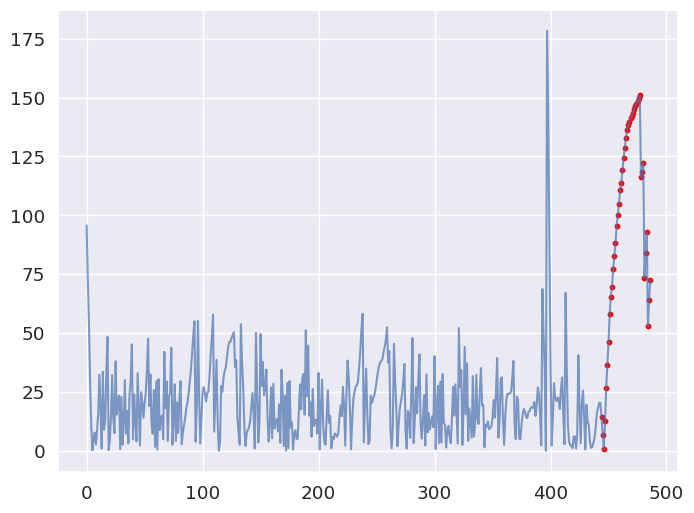

In [46]:
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(rmse_all, label='RMSE', alpha=0.7)  # Plot all RMSE values

# Mark only the '1s' in labels_all on the RMSE plot
ones_indices = np.where(labels_all == 1)[0]  # Indices where labels are 1
plt.scatter(ones_indices, rmse_all[ones_indices], color='red', s=10, label='Anomalies')  # Mark anomalies
plt.savefig("/tf/figures/1d_cnn_example_anomalous_rmses.pdf", facecolor='white')
plt.show()

In [48]:
def apply_sliding_window(rmse_all, labels_all, window_sizes):
    for window_size in window_sizes:
        # Apply sliding window sum for RMSE
        rmse_sum = np.convolve(rmse_all, np.ones(window_size), 'valid') / window_size

        # Apply sliding window for labels to determine the majority
        labels_windowed = np.array([1 if np.sum(labels_all[i:i+window_size]) > window_size // 2 else 0 for i in range(len(labels_all) - window_size + 1)])

        # Evaluate model performance for this window size
        evaluate_model_performance(rmse_sum, labels_windowed, window_size)

def evaluate_model_performance(rmse_sum, labels_windowed, window_size):
    best_metrics = {'F1': 0}
    best_threshold = None
    min_rmse, max_rmse = np.min(rmse_sum), np.max(rmse_sum)

    for threshold in np.linspace(min_rmse, max_rmse, 1000):
        predictions = (rmse_sum > threshold).astype(int)
        f1 = f1_score(labels_windowed, predictions)

        if f1 > best_metrics['F1']:
            best_metrics['F1'] = f1
            best_metrics['Threshold'] = threshold
            best_metrics['Precision'] = precision_score(labels_windowed, predictions)
            best_metrics['Recall'] = recall_score(labels_windowed, predictions)
            best_metrics['Accuracy'] = accuracy_score(labels_windowed, predictions)
            tn, fp, fn, tp = confusion_matrix(labels_windowed, predictions).ravel()
            best_metrics['FPR'] = fp / (fp + tn) if (fp + tn) > 0 else 0
            best_threshold = threshold

    # Count the number of anomaly windows
    num_anomaly_windows = np.sum(labels_windowed)
    
    print(f"Window Size: {window_size}, Best Metrics: {best_metrics}, Number of Anomaly Windows: {num_anomaly_windows}")

# Example window sizes
window_sizes = [1, 29, 31, 33, 35, 37, 39]

apply_sliding_window(rmse_all, labels_all, window_sizes)

Window Size: 1, Best Metrics: {'F1': 0.7804878048780488, 'Threshold': 61.62980931370824, 'Precision': 0.8205128205128205, 'Recall': 0.7441860465116279, 'Accuracy': 0.9630390143737166, 'FPR': 0.015765765765765764}, Number of Anomaly Windows: 43
Window Size: 29, Best Metrics: {'F1': 0.9259259259259259, 'Threshold': 39.99184495249532, 'Precision': 1.0, 'Recall': 0.8620689655172413, 'Accuracy': 0.9912854030501089, 'FPR': 0.0}, Number of Anomaly Windows: 29
Window Size: 31, Best Metrics: {'F1': 0.9433962264150944, 'Threshold': 38.747207785126946, 'Precision': 1.0, 'Recall': 0.8928571428571429, 'Accuracy': 0.9934354485776805, 'FPR': 0.0}, Number of Anomaly Windows: 28
Window Size: 33, Best Metrics: {'F1': 0.9615384615384616, 'Threshold': 37.54878577429709, 'Precision': 1.0, 'Recall': 0.9259259259259259, 'Accuracy': 0.9956043956043956, 'FPR': 0.0}, Number of Anomaly Windows: 27
Window Size: 35, Best Metrics: {'F1': 0.9803921568627451, 'Threshold': 36.33805551856914, 'Precision': 1.0, 'Recall'

#### Method 2: LSTM

In [50]:
patience = 3
batch_size = 32
sequence_stride = 1

def compile_and_fit(model, window, patience=patience):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adamax(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                 [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                  axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
             data=data,
             targets=None,
             sequence_length=self.total_window_size,
             sequence_stride=sequence_stride,
             shuffle=False,
             batch_size=batch_size,)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)
@property
def anol(self):
    return self.make_dataset(self.anol_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, anol_df, label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.anol_df = anol_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.anol = anol
WindowGenerator.example = example

MAX_EPOCHS = 100
NUM_FILTERS = 8
NUM_FEATURES = 1
WINDOW_SIZE = 64
OUT_SIZE = 1

lstm_model = Sequential([
    LSTM(NUM_FILTERS, return_sequences=True, input_shape=(WINDOW_SIZE, NUM_FEATURES)),  # First LSTM layer
    LSTM(NUM_FILTERS, return_sequences=False),  # Second LSTM layer
    Dense(NUM_FEATURES),
    Reshape([OUT_SIZE, NUM_FEATURES])  # Reshaping the output as needed
])

val_performance = {}
loss = {}
val_loss = {}

# Show the model architecture
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64, 8)             320       
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
 reshape_1 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 873 (3.41 KB)
Trainable params: 873 (3.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
# Set window.
w1_lstm = WindowGenerator(input_width=WINDOW_SIZE, label_width=OUT_SIZE, shift=OUT_SIZE,
                          train_df=train_df, val_df=val_df, test_df=test_df, anol_df=anol_df)

# Verify the model input/output shape.
print('Input shape:', w1_lstm.example[0].shape)
print('Output shape:', lstm_model(w1_lstm.example[0]).shape)

Input shape: (32, 64, 1)
Output shape: (32, 1, 1)


In [57]:
# Train the model.
# Compile and evaluate.
history = compile_and_fit(lstm_model, w1_lstm)

Epoch 1/100
124/124 [==============================] - 5s 23ms/step - loss: 0.8441 - root_mean_squared_error: 0.9188 - val_loss: 0.5296 - val_root_mean_squared_error: 0.7278
Epoch 2/100
124/124 [==============================] - 2s 18ms/step - loss: 0.4081 - root_mean_squared_error: 0.6388 - val_loss: 0.3217 - val_root_mean_squared_error: 0.5672
Epoch 3/100
124/124 [==============================] - 2s 18ms/step - loss: 0.2544 - root_mean_squared_error: 0.5044 - val_loss: 0.2081 - val_root_mean_squared_error: 0.4562
Epoch 4/100
124/124 [==============================] - 2s 18ms/step - loss: 0.1629 - root_mean_squared_error: 0.4036 - val_loss: 0.1357 - val_root_mean_squared_error: 0.3684
Epoch 5/100
124/124 [==============================] - 2s 18ms/step - loss: 0.1056 - root_mean_squared_error: 0.3249 - val_loss: 0.0910 - val_root_mean_squared_error: 0.3016
Epoch 6/100
124/124 [==============================] - 2s 18ms/step - loss: 0.0711 - root_mean_squared_error: 0.2667 - val_loss: 0

Saving methods differ. Use first one to easily to load and use (high-level API), for TFLite and TFLite Micro use the second method.

In [47]:
# MODEL_DIR = "/tf/models/lstm_uni_easy"
# # Just save the model; no need for tf.function or concrete functions
# lstm_model.save(MODEL_DIR, save_format="tf")

# # Adjust the input shape for 1D-CNN: batch size, window size for convolution, number of features
# BATCH_SIZE = 1
# STEPS = WINDOW_SIZE
# INPUT_SIZE = NUM_FEATURES

# # Wrap the model call with tf.function for optimization
# run_model = tf.function(lambda x: lstm_model(x))

# # Create a concrete function from the model to fix the input size
# concrete_func = run_model.get_concrete_function(
#     tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], lstm_model.inputs[0].dtype))

# # Model directory to save the TensorFlow SavedModel
# MODEL_DIR = "/tf/models/lstm_univariate"
# lstm_model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

# To load the model, uncomment the following line
MODEL_DIR = "/tf/models/lstm"
lstm_model = tf.keras.models.load_model(MODEL_DIR)

40/40 [==============================] - 0s 8ms/step - loss: 0.0103 - root_mean_squared_error: 0.1017
{'LSTM': [0.010345718823373318, 0.10171390324831009]}


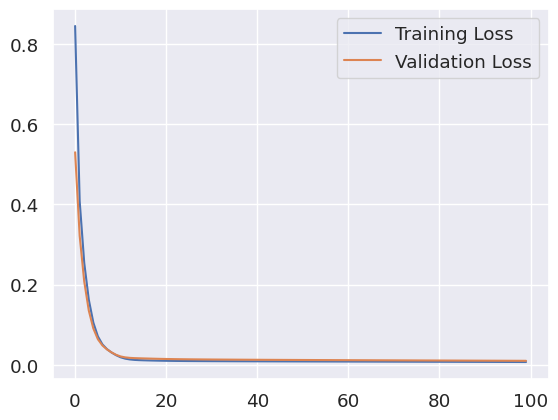

In [59]:
val_performance["LSTM"] = lstm_model.evaluate(w1_lstm.val, verbose=1, return_dict=False)
loss["LSTM"] = history.history["loss"]
val_loss["LSTM"] = history.history["val_loss"]
pprint(val_performance)

# Plot the loss graph.
plt.plot(loss["LSTM"], label='Training Loss')
plt.plot(val_loss["LSTM"], label='Validation Loss')
plt.legend()
plt.savefig("/tf/figures/lstm_uni.pdf", facecolor='white')
plt.show()

In [52]:
# Predict test data.
test_pred_lstm = lstm_model.predict(w1_lstm.test, batch_size=32)
reshaped_test_lstm = test_pred_lstm.reshape(-1, NUM_FEATURES)
rescaled_test_lstm = scaler.inverse_transform(reshaped_test_lstm)
adjusted_test_lstm = test_df_ns.to_numpy()[WINDOW_SIZE:]
rmse_per_row_test_lstm = np.sqrt(np.mean(np.square(rescaled_test_lstm - adjusted_test_lstm), axis=1))

# Predict anomalous data.
anomalous_preds_lstm = lstm_model.predict(w1_lstm.anol, batch_size=32)
reshaped_anol_lstm = anomalous_preds_lstm.reshape(-1, NUM_FEATURES)
rescaled_anol_lstm = scaler.inverse_transform(reshaped_anol_lstm)
adjusted_anol_lstm = anol_df_ns.to_numpy()[WINDOW_SIZE:]
rmse_per_row_anol_lstm = np.sqrt(np.mean(np.square(rescaled_anol_lstm - adjusted_anol_lstm), axis=1))

3/3 [==============================] - 0s 6ms/step


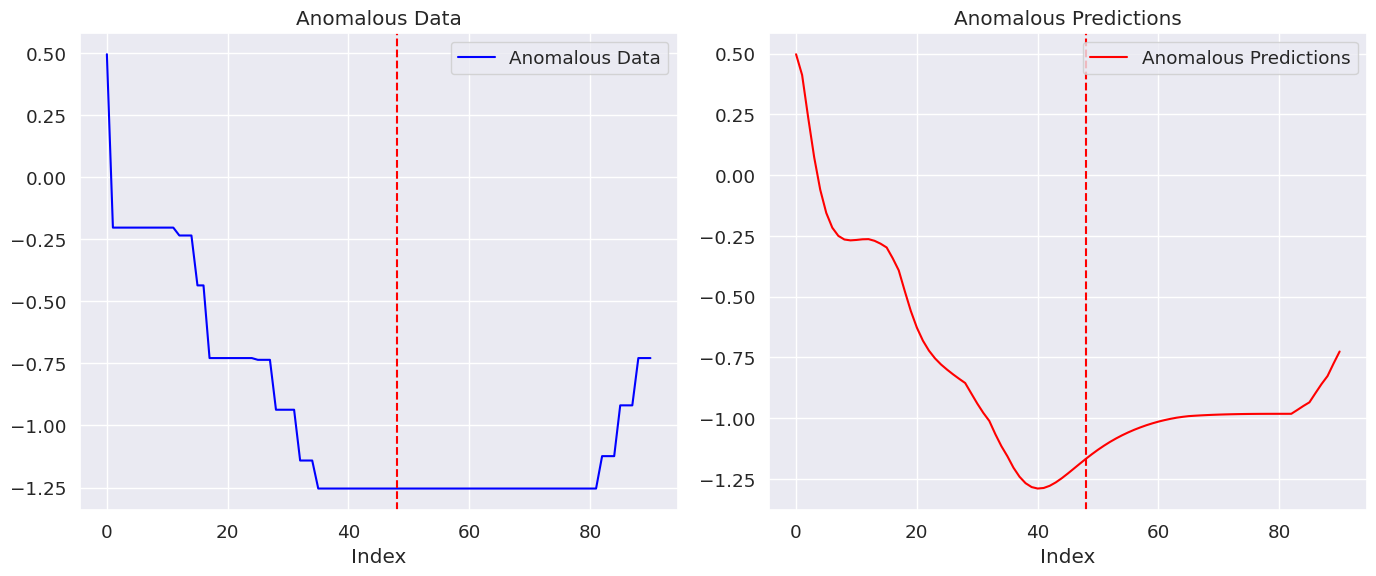

In [62]:
# Reshaping the predictions for plotting
anomalous_pred_reshaped = anomalous_preds_lstm.reshape(-1)

# Plotting
plt.figure(figsize=(14, 6))

# Plotting test predictions
plt.subplot(1, 2, 1)
plt.plot(anol_df[WINDOW_SIZE:].to_numpy(), label='Anomalous Data', color='blue')
plt.axvline(x=48, color='red', linestyle='--')
plt.title('Anomalous Data')
plt.xlabel('Index')
plt.legend()

# Plotting anomalous predictions
plt.subplot(1, 2, 2)
plt.plot(anomalous_pred_reshaped, label='Anomalous Predictions', color='red')
plt.axvline(x=48, color='red', linestyle='--')
plt.title('Anomalous Predictions')
plt.xlabel('Index')
plt.legend()

plt.tight_layout()
plt.show()

Index of the first occurrence of 1: 112


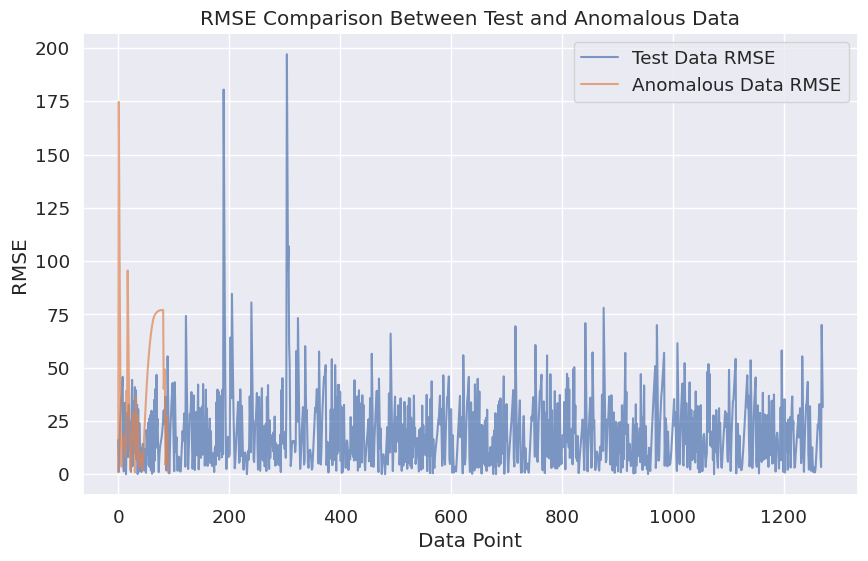

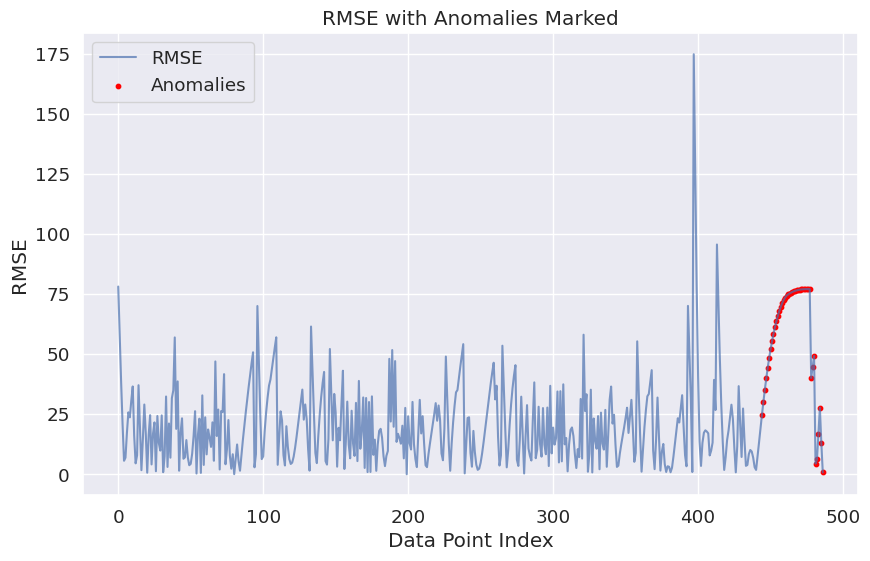

Window Size: 1, Best Metrics: {'F1': 0.6666666666666666, 'Threshold': 58.13272806497905, 'Precision': 0.7428571428571429, 'Recall': 0.6046511627906976, 'Accuracy': 0.946611909650924, 'FPR': 0.02027027027027027}, Number of Anomaly Windows: 43
Window Size: 3, Best Metrics: {'F1': 0.725, 'Threshold': 50.807632364827384, 'Precision': 0.7631578947368421, 'Recall': 0.6904761904761905, 'Accuracy': 0.954639175257732, 'FPR': 0.020316027088036117}, Number of Anomaly Windows: 42
Window Size: 33, Best Metrics: {'F1': 0.9615384615384616, 'Threshold': 35.9020435128325, 'Precision': 1.0, 'Recall': 0.9259259259259259, 'Accuracy': 0.9956043956043956, 'FPR': 0.0}, Number of Anomaly Windows: 27
Window Size: 35, Best Metrics: {'F1': 1.0, 'Threshold': 34.39634209361077, 'Precision': 1.0, 'Recall': 1.0, 'Accuracy': 1.0, 'FPR': 0.0}, Number of Anomaly Windows: 26
Window Size: 37, Best Metrics: {'F1': 1.0, 'Threshold': 33.48956618468857, 'Precision': 1.0, 'Recall': 1.0, 'Accuracy': 1.0, 'FPR': 0.0}, Number of

In [70]:
# Find the indices where the value is 1
indices = np.where(anol_labels == 1)[0]

# Get the first occurrence if it exists
first_occurrence = indices[0] if len(indices) > 0 else None

print("Index of the first occurrence of 1:", first_occurrence)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(rmse_per_row_test_lstm, label='Test Data RMSE', alpha=0.7)
plt.plot(rmse_per_row_anol_lstm, label='Anomalous Data RMSE', alpha=0.7)
plt.title('RMSE Comparison Between Test and Anomalous Data')
plt.xlabel('Data Point')
plt.ylabel('RMSE')
plt.legend()
plt.savefig("/tf/figures/rmses_lstm.pdf", facecolor='white')
plt.show()

# Cut to balance a bit.
CUT_NUMBER = 875

# We cannot predict the first 64.
anol_labels_cut = anol_labels[64:]
nor_labels = np.zeros(len(rmse_per_row_test_lstm[CUT_NUMBER:]))

# Concatenate rmse_per_row_test and rmse_per_row_anol
rmse_all = np.concatenate((rmse_per_row_test_lstm[CUT_NUMBER:], rmse_per_row_anol_lstm))
labels_all = np.concatenate((nor_labels, anol_labels_cut))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(rmse_all, label='RMSE', alpha=0.7)  # Plot all RMSE values

# Mark only the '1s' in labels_all on the RMSE plot
ones_indices = np.where(labels_all == 1)[0]  # Indices where labels are 1
plt.scatter(ones_indices, rmse_all[ones_indices], color='red', s=10, label='Anomalies')  # Mark anomalies

plt.title('RMSE with Anomalies Marked')
plt.xlabel('Data Point Index')
plt.ylabel('RMSE')
plt.legend()
plt.show()

def apply_sliding_window(rmse_all, labels_all, window_sizes):
    for window_size in window_sizes:
        # Apply sliding window sum for RMSE
        rmse_sum = np.convolve(rmse_all, np.ones(window_size), 'valid') / window_size

        # Apply sliding window for labels to determine the majority
        labels_windowed = np.array([1 if np.sum(labels_all[i:i+window_size]) > window_size // 2 else 0 for i in range(len(labels_all) - window_size + 1)])

        # Evaluate model performance for this window size
        evaluate_model_performance(rmse_sum, labels_windowed, window_size)

def evaluate_model_performance(rmse_sum, labels_windowed, window_size):
    best_metrics = {'F1': 0}
    best_threshold = None
    min_rmse, max_rmse = np.min(rmse_sum), np.max(rmse_sum)

    for threshold in np.linspace(min_rmse, max_rmse, 1000):
        predictions = (rmse_sum > threshold).astype(int)
        f1 = f1_score(labels_windowed, predictions)

        if f1 > best_metrics['F1']:
            best_metrics['F1'] = f1
            best_metrics['Threshold'] = threshold
            best_metrics['Precision'] = precision_score(labels_windowed, predictions)
            best_metrics['Recall'] = recall_score(labels_windowed, predictions)
            best_metrics['Accuracy'] = accuracy_score(labels_windowed, predictions)
            tn, fp, fn, tp = confusion_matrix(labels_windowed, predictions).ravel()
            best_metrics['FPR'] = fp / (fp + tn) if (fp + tn) > 0 else 0
            best_threshold = threshold

    # Count the number of anomaly windows
    num_anomaly_windows = np.sum(labels_windowed)
    
    print(f"Window Size: {window_size}, Best Metrics: {best_metrics}, Number of Anomaly Windows: {num_anomaly_windows}")

# Example window sizes
window_sizes = [1,3, 33, 35, 37]

apply_sliding_window(rmse_all, labels_all, window_sizes)

### Arm Position

#### Statistical Analysis

In [4]:
anomaly_data_arm = arm_pos_anomalous_df.copy()
training_data_arm = arm_pos_training_df.copy()

columns_to_describe_arm = [
    'z(ns=2;i=4)', 
    'y(ns=2;i=3)', 
    'pitch(ns=2;i=6)', 
    'x(ns=2;i=2)', 
    'yaw(ns=2;i=7)',
    'roll(ns=2;i=5)'
]

# Calculate statistical features for the specified columns in both datasets
anomaly_stats_arm = anomaly_data_arm[columns_to_describe_arm].describe()
training_stats_arm = training_data_arm[columns_to_describe_arm].describe()

# Comparing statistical features
comparison_arm = pd.concat([training_stats_arm, anomaly_stats_arm], axis=1, keys=['Training Data', 'Anomaly Data'])

comparison_arm

Training Data                                                          \
        z(ns=2;i=4)  y(ns=2;i=3) pitch(ns=2;i=6)  x(ns=2;i=2) yaw(ns=2;i=7)   
count   4235.000000  4235.000000     4235.000000  4235.000000   4235.000000   
mean     171.053187    -1.512626       -0.148426   193.469021      1.478183   
std       19.395465   192.945112        0.087171     3.872895      0.876652   
min      133.498566  -293.569855       -0.234168   189.632996     -0.000000   
25%      156.747665  -172.023010       -0.234168   189.632996      0.672595   
50%      176.176071     0.000000       -0.173606   192.398987      1.720306   
75%      184.124420   162.626297       -0.069099   197.027679      2.346549   
max      200.000000   306.739258       -0.000000   200.000000      2.346549   

                     Anomaly Data                                          \
      roll(ns=2;i=5)  z(ns=2;i=4) y(ns=2;i=3) pitch(ns=2;i=6) x(ns=2;i=2)   
count    4235.000000    75.000000   75.000000       75.000000   75.000000   
mean      152.925672   168.565052   18.845133       -0.160062  193.131320   
std        94.386835    18.187783  199.955719        0.078768    3.783539   
min      -180.000020   133.498566 -293.569824       -0.234168  189.632996   
25%       179.527100   156.814606 -152.148010       -0.234168  189.632996   
50%       179.588980   174.476624    2.582639       -0.185925  191.841965   
75%       179.807391   176.176270  219.735397       -0.110008  195.235397   
max       179.999963   200.000000  306.739258       -0.000000  200.000000   

                                    
      yaw(ns=2;i=7) roll(ns=2;i=5)  
count     75.000000      75.000000  
mean       1.585850     141.285556  
std        0.807841     111.767076  
min       -0.000000    -180.000020  
25%        1.078192     179.527100  
50%        1.846414     179.540393  
75%        2.346549     179.756112  
max        2.346549     179.904393

We do not see differences in min-max. The biggest difference is:

- y mean => -2 (non-anomalous) | 19 (anomalous)

We will plot to gain more insight. Anomalous data first.

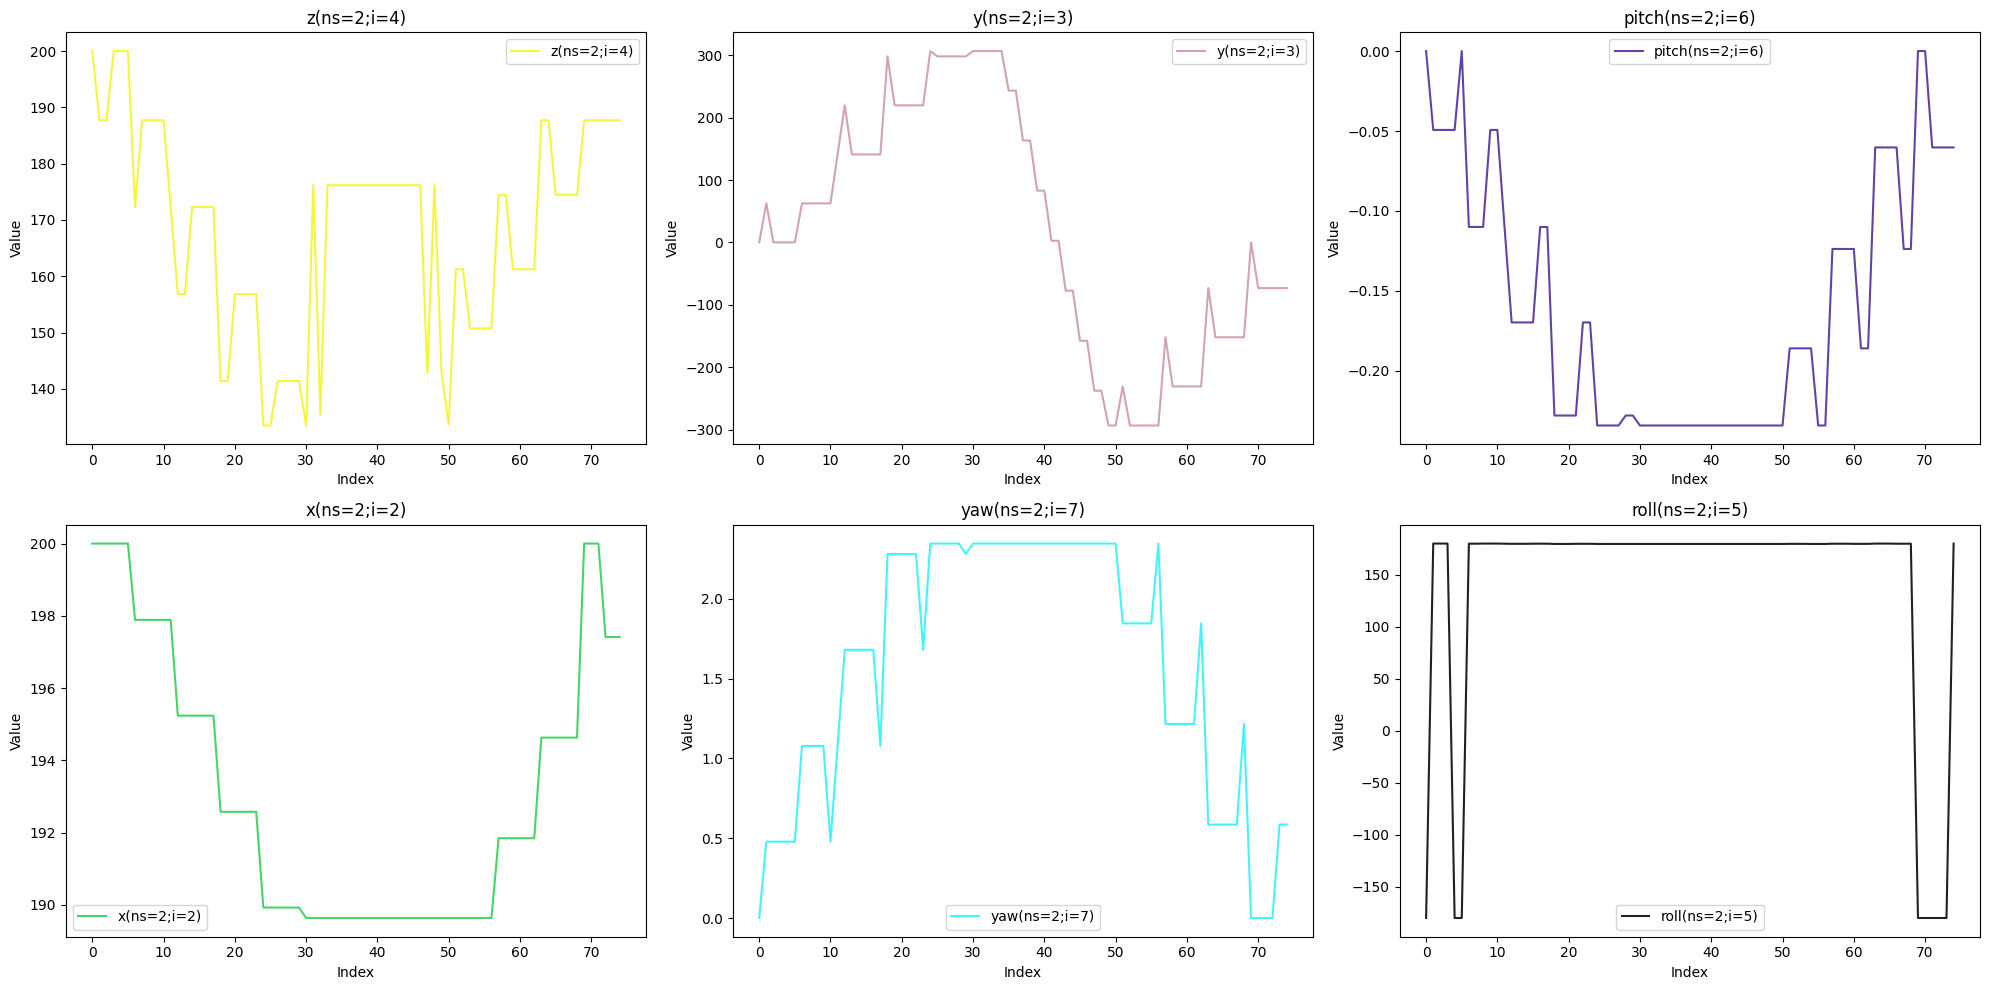

In [5]:
plt.figure(figsize=(20, 10))

for i, col in enumerate(columns_to_describe_arm, 1):
    plt.subplot(2, 3, i)
    plt.plot(anomaly_data_arm.index, anomaly_data_arm[col], label=col, color=np.random.rand(3,))
    plt.title(col)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

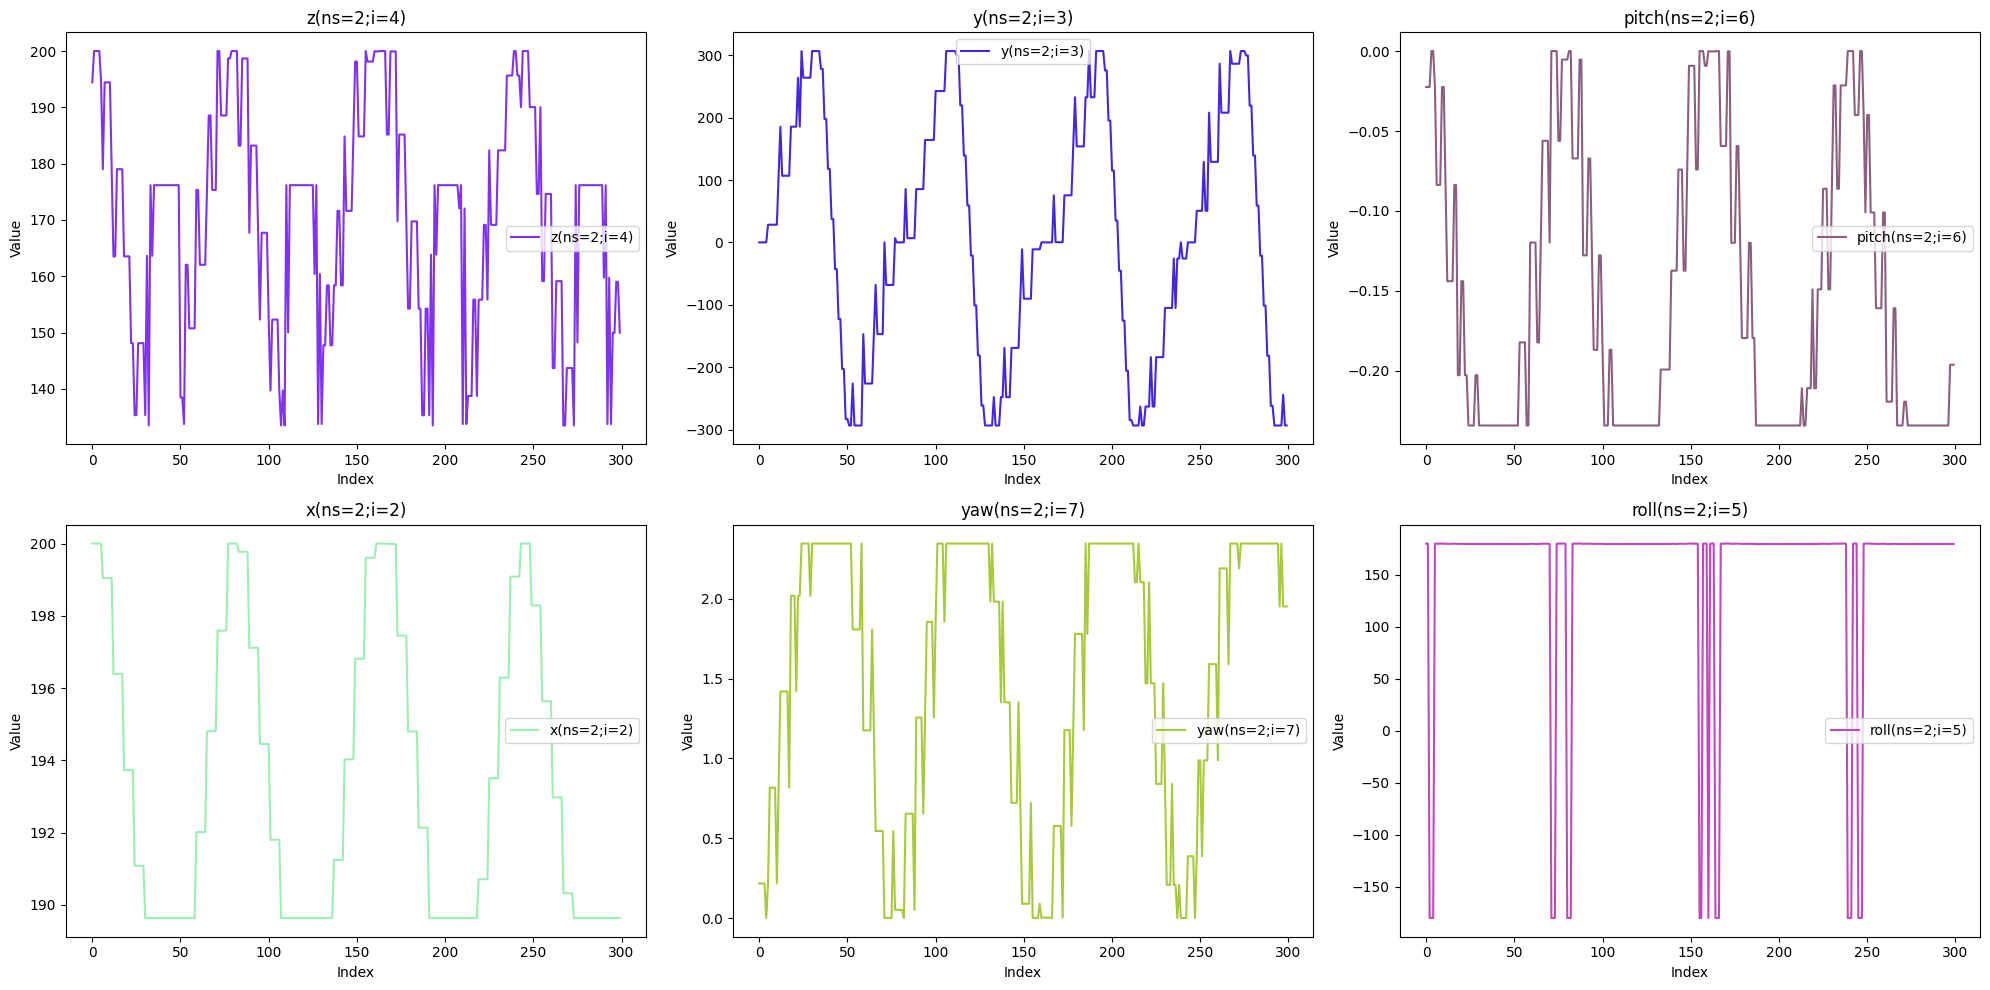

In [6]:
plt.figure(figsize=(20, 10))

for i, col in enumerate(columns_to_describe_arm, 1):
    plt.subplot(2, 3, i)
    # Limit the plot to the first 200 data points
    plt.plot(training_data_arm.index[:300], training_data_arm[col][:300], label=col, color=np.random.rand(3,))
    plt.title(col)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

In [45]:
###
# Run for Multivariate
###
non_anol_numeric = training_data_arm[['z(ns=2;i=4)', 'y(ns=2;i=3)', 'pitch(ns=2;i=6)', 'x(ns=2;i=2)', 'yaw(ns=2;i=7)', 'roll(ns=2;i=5)']]
anol_numeric = anomaly_data_arm[['z(ns=2;i=4)', 'y(ns=2;i=3)', 'pitch(ns=2;i=6)', 'x(ns=2;i=2)', 'yaw(ns=2;i=7)', 'roll(ns=2;i=5)']]

# non_anol_numeric = training_data_arm['y(ns=2;i=3)']
# anol_numeric = anomaly_data_arm['y(ns=2;i=3)']

# Calculate split indices
train_size = int(len(non_anol_numeric) * 0.6)
val_size = int(len(non_anol_numeric) * 0.2)

# Split the 'Speed Out' column from 'con'
train_df_ns = non_anol_numeric.iloc[:train_size][['y(ns=2;i=3)']]
val_df_ns = non_anol_numeric.iloc[train_size:train_size + val_size][['y(ns=2;i=3)']]
test_df_ns = non_anol_numeric.iloc[train_size + val_size:][['y(ns=2;i=3)']]
anol_df_ns = anol_numeric[['y(ns=2;i=3)']]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
train_scaled = scaler.fit_transform(train_df_ns)
val_scaled = scaler.transform(val_df_ns)
test_scaled = scaler.transform(test_df_ns)
anol_scaled = scaler.transform(anol_df_ns)

# Convert scaled numpy arrays back to pandas DataFrames with 'Speed Out' as the column
train_df = pd.DataFrame(train_scaled, columns=['y(ns=2;i=3)'], index=train_df_ns.index)
val_df = pd.DataFrame(val_scaled, columns=['y(ns=2;i=3)'], index=val_df_ns.index)
test_df = pd.DataFrame(test_scaled, columns=['y(ns=2;i=3)'], index=test_df_ns.index)
anol_df = pd.DataFrame(anol_scaled, columns=['y(ns=2;i=3)'], index=anol_df_ns.index)

# Check the lengths
print("Lengths: ", len(train_scaled), len(val_scaled), len(test_scaled), len(anol_scaled))
print("Lengths: ", len(train_df), len(val_df), len(test_df), len(anol_df))

Lengths:  2541 847 847 75
Lengths:  2541 847 847 75


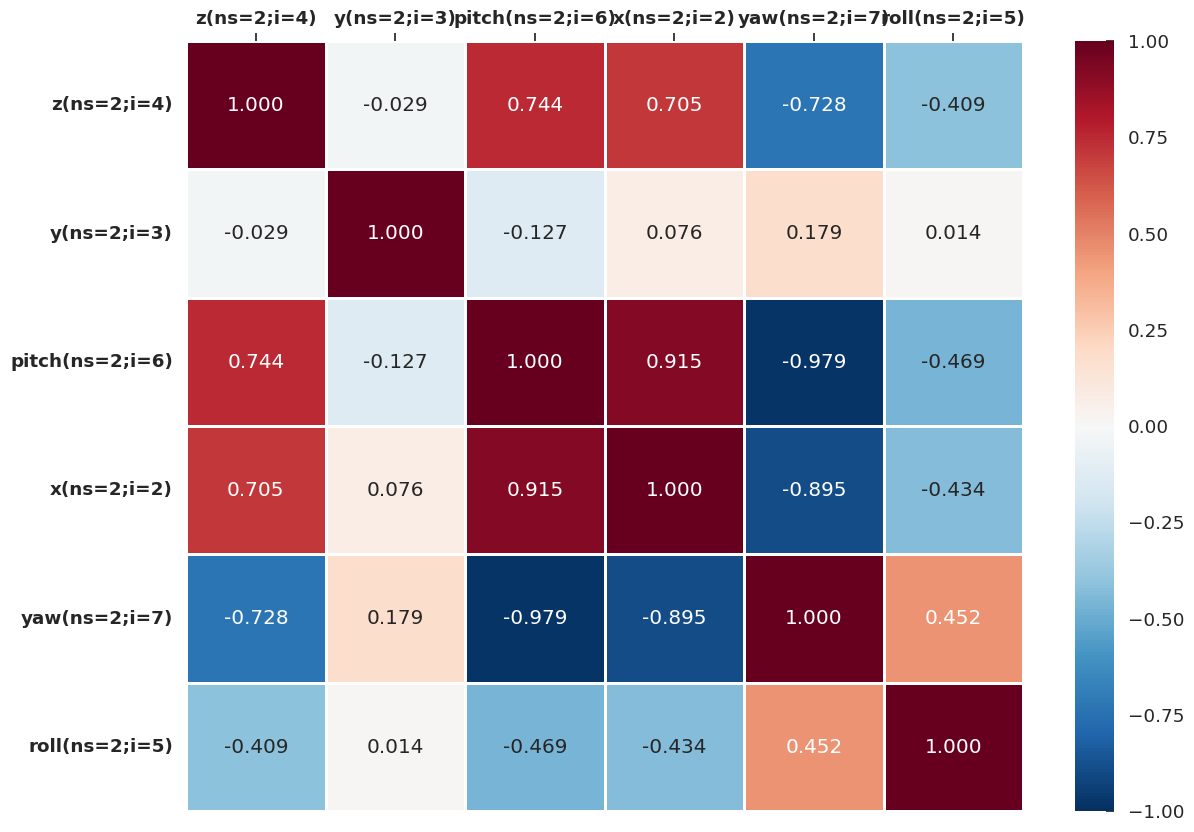

In [46]:
# Calculate the correlation matrix
corr = training_data_arm[['z(ns=2;i=4)', 'y(ns=2;i=3)', 'pitch(ns=2;i=6)', 'x(ns=2;i=2)', 'yaw(ns=2;i=7)', 'roll(ns=2;i=5)']].corr()

# Set the size of the figure
plt.figure(figsize=(13.5, 10))

# Increase the font size for readability
sns.set(font_scale=1.2)

# Generate a heatmap with customized styling
ax = sns.heatmap(corr, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, vmax=1, 
                 cbar=True, fmt='.3f', annot_kws={"fontweight": "light"},
                 square=False, xticklabels=corr.columns, yticklabels=corr.columns)

# Get the colorbar object from the heatmap and adjust its position
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(pad=10, direction='in', labelright=True, labelleft=False)

# Adjust tick positions and labels for clarity
ax.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')

# Save the figure as a PDF with high resolution
plt.savefig('/tf/figures/corr_heatmap.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

We see that **yaw, pitch and x** very highly correlate with each other, while they also correlate with **z**. Now we check **autocorrelation**.

In [47]:
def plot_autocorrelation_and_peaks(data):
    # Check if the data is a Series and convert it to DataFrame if so
    if isinstance(data, pd.Series):
        data = data.to_frame()
    
    for column in data.columns:
        # Compute the autocorrelation
        autocorrelation = acf(data[column], nlags=160, fft=True)
        
        # Find peaks
        peaks, _ = find_peaks(autocorrelation)
        neg_peaks, _ = find_peaks(-autocorrelation)  # For negative peaks
        
        # # Plotting the autocorrelation
        # plt.figure(figsize=(10, 5))
        # plt.plot(autocorrelation, label='Autocorrelation')
        
        # # Marking the positive peaks
        # plt.plot(peaks, autocorrelation[peaks], "x", label='Positive Peaks')
        
        # # Marking the negative peaks
        # plt.plot(neg_peaks, autocorrelation[neg_peaks], "x", color='red', label='Negative Peaks')
        
        # plt.title(f'Autocorrelation of {column}')
        # plt.xlabel('Lags')
        # plt.ylabel('Autocorrelation')
        # plt.legend()
        # plt.show()
        
        # Print the lags where peaks occur
        print(f"Feature: {column}")
        print(f"Positive peaks are at lags: {peaks}")
        print(f"Negative peaks are at lags: {neg_peaks}\n")

plot_autocorrelation_and_peaks(non_anol_numeric)

Feature: z(ns=2;i=4)
Positive peaks are at lags: [ 17  19  34  39  43  49  55  82 121 141]
Negative peaks are at lags: [ 16  18  21  35  41  48  54  60 102 140 142]

Feature: y(ns=2;i=3)
Positive peaks are at lags: [40 42 82]
Negative peaks are at lags: [ 39  41  43 122]

Feature: pitch(ns=2;i=6)
Positive peaks are at lags: [ 5 82]
Negative peaks are at lags: [  4  41 123]

Feature: x(ns=2;i=2)
Positive peaks are at lags: [82]
Negative peaks are at lags: [ 41 123]

Feature: yaw(ns=2;i=7)
Positive peaks are at lags: [ 6 82]
Negative peaks are at lags: [  5  42 123]

Feature: roll(ns=2;i=5)
Positive peaks are at lags: [  5   9  14  24  30  35  68  73  78  82  91 112 117 145 159]
Negative peaks are at lags: [  3   7  12  15  26  33  65  69  75  79  89  96 115 142 148]



We have negative peaks at **40**, so seems like a good input window size. **80** is a better choice but due to lack of anomalous data we cannot select that.

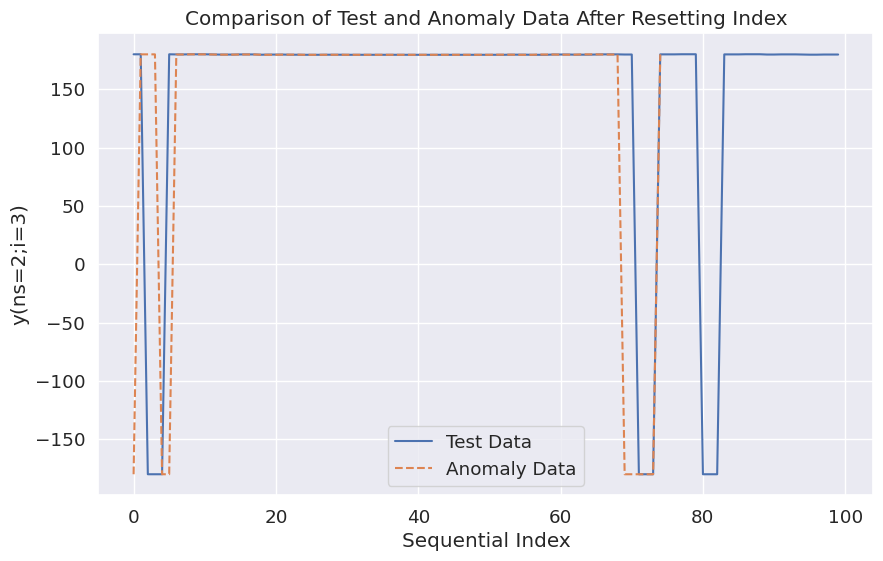

In [48]:
# Reset the index of each dataframe and keep only the first 100 points
test_points_reset = training_data_arm['roll(ns=2;i=5)'].reset_index(drop=True).iloc[:100]
anol_points_reset = anomaly_data_arm['roll(ns=2;i=5)'].reset_index(drop=True).iloc[:100]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(test_points_reset.index, test_points_reset, label='Test Data')
plt.plot(anol_points_reset.index, anol_points_reset, label='Anomaly Data', linestyle='--')
plt.title('Comparison of Test and Anomaly Data After Resetting Index')
plt.xlabel('Sequential Index')
plt.ylabel('y(ns=2;i=3)')
plt.legend()
plt.show()

#### 1D-CNN

In [49]:
patience = 3
batch_size = 32
sequence_stride = 1
WIN_SIZE_CONV = 40
CONV_WIDTH = 3
MAX_EPOCHS = 100
NUM_FILTERS = 8
MAX_POOL_SIZE = 3
NUM_FEATURES = 1
OUT_SIZE = 1

def compile_and_fit(model, window, patience=patience):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adamax(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                 [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                  axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
             data=data,
             targets=None,
             sequence_length=self.total_window_size,
             sequence_stride=sequence_stride,
             shuffle=False,
             batch_size=batch_size,)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)
@property
def anol(self):
    return self.make_dataset(self.anol_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, anol_df, label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.anol_df = anol_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.anol = anol
WindowGenerator.example = example

# Set neural network model/parameters.
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    # tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    # tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    # tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT_SIZE*NUM_FEATURES, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_SIZE, NUM_FEATURES])
])

val_performance = {}
loss = {}
val_loss = {}

cnn_model.build(input_shape=(None, WIN_SIZE_CONV, NUM_FEATURES))
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 38, 8)             32        
                                                                 
 conv1d_7 (Conv1D)           (None, 36, 8)             200       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 12, 8)             0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 96)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 97        
                                                                 
 reshape_3 (Reshape)         (None, 1, 1)              0         
                                                      

In [50]:
# Set window.
w1_con = WindowGenerator(input_width=WIN_SIZE_CONV, label_width=OUT_SIZE, shift=OUT_SIZE,
                     train_df=train_df, val_df=val_df, test_df=test_df, anol_df=anol_df)

# Verify the model input/output shape.
print('Input shape:', w1_con.example[0].shape)
print('Output shape:', cnn_model(w1_con.example[0]).shape)

Input shape: (32, 40, 1)
Output shape: (32, 1, 1)


In [51]:
# Train the model.
# Compile and evaluate.
history = compile_and_fit(cnn_model, w1_con)

Epoch 1/100
79/79 [==============================] - 2s 9ms/step - loss: 0.8830 - root_mean_squared_error: 0.9397 - val_loss: 0.7073 - val_root_mean_squared_error: 0.8410
Epoch 2/100
79/79 [==============================] - 1s 8ms/step - loss: 0.4752 - root_mean_squared_error: 0.6893 - val_loss: 0.2898 - val_root_mean_squared_error: 0.5384
Epoch 3/100
79/79 [==============================] - 1s 8ms/step - loss: 0.2023 - root_mean_squared_error: 0.4497 - val_loss: 0.1549 - val_root_mean_squared_error: 0.3935
Epoch 4/100
79/79 [==============================] - 1s 8ms/step - loss: 0.1205 - root_mean_squared_error: 0.3471 - val_loss: 0.0955 - val_root_mean_squared_error: 0.3091
Epoch 5/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0779 - root_mean_squared_error: 0.2791 - val_loss: 0.0643 - val_root_mean_squared_error: 0.2535
Epoch 6/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0566 - root_mean_squared_error: 0.2379 - val_loss: 0.0498 - val_root_m

In [52]:
MODEL_DIR = "/tf/models/1d_cnn_uni_arm"

# Just save the model; no need for tf.function or concrete functions
cnn_model.save(MODEL_DIR, save_format="tf")

# # Adjust the input shape for 1D-CNN: batch size, window size for convolution, number of features
# BATCH_SIZE = 1
# STEPS = WIN_SIZE_CONV 
# INPUT_SIZE = NUM_FEATURES

# # Wrap the model call with tf.function for optimization
# run_model = tf.function(lambda x: cnn_model(x))

# # Create a concrete function from the model to fix the input size
# concrete_func = run_model.get_concrete_function(
#     tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], cnn_model.inputs[0].dtype))

# # Model directory to save the TensorFlow SavedModel
# MODEL_DIR = "/tf/models/1d_cnn_uni"
# cnn_model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

# # To load the model, uncomment the following line
# MODEL_DIR = "/tf/models/1d_cnn_uni"
# cnn_model = tf.saved_model.load(MODEL_DIR)

INFO:tensorflow:Assets written to: /tf/models/1d_cnn_uni_arm/assets


INFO:tensorflow:Assets written to: /tf/models/1d_cnn_uni_arm/assets


26/26 [==============================] - 0s 4ms/step - loss: 0.0246 - root_mean_squared_error: 0.1569
{'1D-CNN': [0.024623706936836243, 0.1569194346666336]}


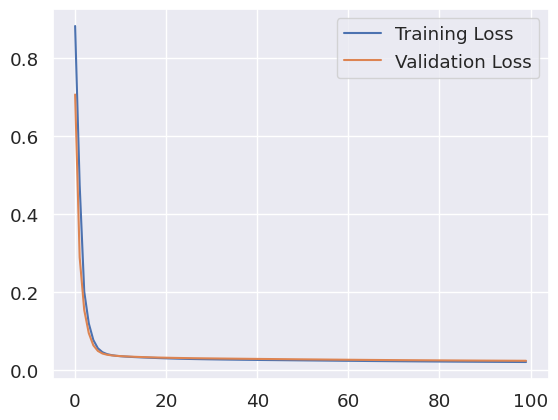

In [53]:
val_performance["1D-CNN"] = cnn_model.evaluate(w1_con.val, verbose=1, return_dict=False)
loss["1D-CNN"] = history.history["loss"]
val_loss["1D-CNN"] = history.history["val_loss"]
pprint(val_performance)

# Plot the loss graph.
plt.plot(loss["1D-CNN"], label='Training Loss')
plt.plot(val_loss["1D-CNN"], label='Validation Loss')
plt.legend()
plt.savefig("/tf/figures/1d_cnn_uni_arm.pdf", facecolor='white')
plt.show()

In [54]:
# Predict test data.
test_pred = cnn_model.predict(w1_con.test, batch_size=32)
reshaped_test = test_pred.reshape(-1, NUM_FEATURES)
rescaled_test = scaler.inverse_transform(reshaped_test)
adjusted_test = test_df_ns.to_numpy()[WIN_SIZE_CONV:]
rmse_per_row_test = np.sqrt(np.mean(np.square(rescaled_test - adjusted_test), axis=1))

# Predict anomalous data.
anomalous_preds = cnn_model.predict(w1_con.anol, batch_size=32)
reshaped_ha = anomalous_preds.reshape(-1, NUM_FEATURES)
rescaled_ha = scaler.inverse_transform(reshaped_ha)
adjusted_ha = anol_df_ns.to_numpy()[WIN_SIZE_CONV:]
rmse_per_row_anol = np.sqrt(np.mean(np.square(rescaled_ha - adjusted_ha), axis=1))

2/2 [==============================] - 0s 3ms/step


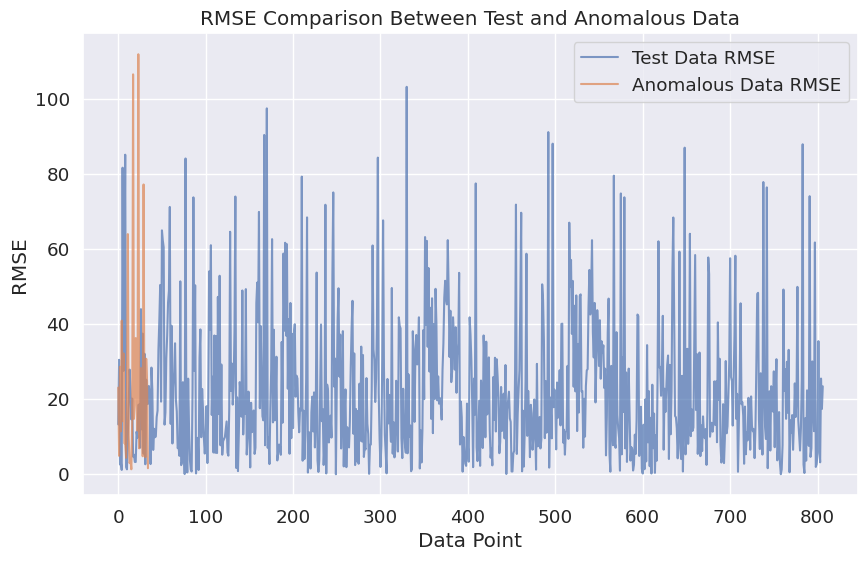

In [55]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(rmse_per_row_test, label='Test Data RMSE', alpha=0.7)
plt.plot(rmse_per_row_anol, label='Anomalous Data RMSE', alpha=0.7)
plt.title('RMSE Comparison Between Test and Anomalous Data')
plt.xlabel('Data Point')
plt.ylabel('RMSE')
plt.legend()
plt.savefig("/tf/figures/rmses_arm.pdf", facecolor='white')
plt.show()

We do not see any differences so anomaly detection cannot be implemented.